## Импорт библиотек

In [52]:
import warnings
warnings.filterwarnings('ignore')

import os
import io
import json
import shutil
import random
import zipfile
import requests

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm.auto import trange

from scipy.signal import welch
from scipy.stats import kurtosis, skew
from scipy.signal.windows import blackman

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout

## Обработка данных, полученных после проведения реальных полётов

#### Загрузка данных с GitHub

In [ ]:
url = "https://github.com/tiiuae/UAV-Realistic-Fault-Dataset/archive/refs/heads/main.zip"
response = requests.get(url)

zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall("UAV-Realistic-Fault-Dataset")

#### Парсинг данных

In [ ]:
base_dir = r'UAV-Realistic-Fault-Dataset\UAV-Realistic-Fault-Dataset-main\Dataset'
processed_dir = 'Data_Real'
os.makedirs(processed_dir, exist_ok=True)

for folder in trange(5, desc='Progress', colour='blue'):
    folder_path = os.path.join(base_dir, str(folder))
    file_number = 0
    
    class_folder = os.path.join(processed_dir, str(folder))
    os.makedirs(class_folder, exist_ok=True)

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            combined_data = []
            
            for file in os.listdir(subfolder_path):
                if file.endswith('SensorCombined.jsonl'):
                    
                    with open(os.path.join(subfolder_path, file), 'r') as jsonl_file:
                        for line in jsonl_file:
                            data = json.loads(line)
                            combined_data.append(data)

                        df = pd.DataFrame(combined_data)                        
                        for i, row in enumerate(df['gyro_rad']):
                            df.loc[i, ['gx', 'gy', 'gz']] = row
                            
                        for i, row in enumerate(df['accelerometer_m_s2']):
                            df.loc[i, ['ax', 'ay', 'az']] = row

                        df.drop(columns=["gyro_rad", "accelerometer_m_s2", 
                                         "accelerometer_timestamp_relative", 
                                         "accelerometer_clipping", 
                                         'gyro_integral_dt', 
                                         'accelerometer_integral_dt'], inplace=True)
                        
                        df.rename(columns={'timestamp': 'time'
                                          }, inplace=True)
                        
                        df.to_csv(os.path.join(class_folder, f"class_{folder}_number_{file_number}.csv"), index=False)
                        file_number += 1

    combined_class_data = []
    for file in os.listdir(class_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(class_folder, file)
            class_df = pd.read_csv(file_path)
            combined_class_data.append(class_df)

    if combined_class_data:
        final_df = pd.concat(combined_class_data, ignore_index=True)
        final_df.to_csv(os.path.join(class_folder, f"class_{folder}_merged.csv"), index=False)

In [2]:
# Убедимся, что данные корректно записались
test_data = pd.read_csv(r"Data_Real\0\class_0_merged.csv")
test_data.head(5)

time  gInt  aInt        gx        gy        gz        ax        ay  \
0  947975062  4998  4998  0.008529  0.004348 -0.001269  0.145165 -0.034807   
1  947976312  4996  4996  0.001431  0.005915 -0.001310  0.116024  0.020439   
2  947983469  4998  4998  0.016173  0.007350  0.000573  0.092866  0.060234   
3  947996546  4994  4994 -0.001588  0.000100 -0.003505  0.065213  0.016342   
4  947995456  4995  4995  0.008024  0.012801  0.000042  0.082880  0.064342   

         az  
0 -9.828311  
1 -9.769987  
2 -9.827328  
3 -9.804899  
4 -9.800008

#### Удаление ненужных данных

In [3]:
folder_path = 'UAV-Realistic-Fault-Dataset'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

#### Вычисление частоты дискретизации

Частота дискретизации акселерометра и гироскопа нигде не указана, поэтому вычислим её самостоятельно.

In [4]:
lst = []
for clas in range(5):
    for num in range(20):
        
        if clas == 0 and num == 19: continue                                    # Так как в классе "0" меньше на 1 файл
        data = pd.read_csv(rf"Data_Real\{clas}\class_{clas}_number_{num}.csv")  # Считываем данные
        data = data.sort_values(by='time')                                      # Сортируем по времени
        time_differences = (data['time'].diff().abs()).dropna()                 # Рассчитываем разницу между всеми соседними
        average_difference = time_differences.mean() / 10**6                    # Переводим в секунды из микросекунд
        lst.append(1 / average_difference)                                      # Сохраняем

print(f"Рассчитанная частота дискретизации: {round(sum(lst) / len(lst))}")

Рассчитанная частота дискретизации: 195


## Построение спектрограмм

In [5]:
def plot_3d_spectrogram(data_dir, Fs, window_size, stride):

    channels = ["gx", "gy", "gz", "ax", "ay", "az"]
    
    window = blackman(window_size)                     # Окно Блэкмана-Наталла для уменьшения утечки спектра
    more10hz = round(window_size / Fs * 10)            # Индекс для частот более 10 Гц
    frequencies = np.fft.fftfreq(window_size, 1 / Fs)  # Получение частот для спектра

    class_folders = os.listdir(f"{data_dir}") 

    for class_label in class_folders:
        folder_path = os.path.join(data_dir, class_label)   
        file_names = [name for name in os.listdir(folder_path) if "merged" not in name and name.endswith('.csv')]
        amplitude = []
        
        for file_name in file_names:
            file_path = os.path.join(folder_path, file_name)
    
            # Загрузка данных из CSV-файла и извлечение значений гироскопа и акселерометра
            df = pd.read_csv(file_path)
            data = df[channels].values  
            
            data[:, 5] += 9.81
            
            # Скользящее окно по даннымс заданным шагом
            for start in range(0, len(data) - window_size + 1, stride):
                segment = data[start:start + window_size]
                segment_windowed = segment * window[:, None]  # Наложение окна
                
                yf = np.fft.fft(segment_windowed, axis=0)     # Применение БПФ
                amplitude.append(np.abs(yf))                  # Извлечение амплитуд; shape = (num_windows, window_size, 6)

        amplitude = np.array(amplitude)
        fig = plt.figure(figsize=(20, 14))
    
        for i in range(len(channels)):
            ax = fig.add_subplot(2, 3, i + 1, projection='3d')
            
            time_axis = np.arange(len(amplitude))
            frequency_axis = frequencies[:window_size // 2]
            amplitude_channel = amplitude[:, :window_size // 2, i]
            time_axis_grid, frequency_axis_grid = np.meshgrid(time_axis, frequency_axis)
            
            ax.plot_surface(time_axis_grid, frequency_axis_grid, amplitude_channel.T, cmap='viridis')
            ax.set_title(f'3D Спектрограмма для {channels[i]}, class {class_label}', size=12)
            ax.set_xlabel('Номер окна')
            ax.set_ylabel('Частота (Гц)')
            ax.set_zlabel('Амплитуда')
            
        # plt.savefig(f'3D_spectrogram_class_{class_label}.png', dpi=300, bbox_inches='tight')
        plt.show()

Данные из папки Data_Matlab были получены мной при проведении 15 полётов для каждого класса неисправности в симуляционном комплексе при частоте дискретизации 200 Гц: 

Исправен           (0) — тяга всех двигателей 100% 

Неполадки в работе (1) — тяга одного из двигателей 80% 

Аварийная ситуация (2) — тяга одного из двигателей 60%

In [6]:
# Настройки
data_dir = "Data_Real" # "Data_Real", "Data_MatLab"
window_size = 256
stride = 64

Fs = 195 if data_dir == "Data_Real" else 200

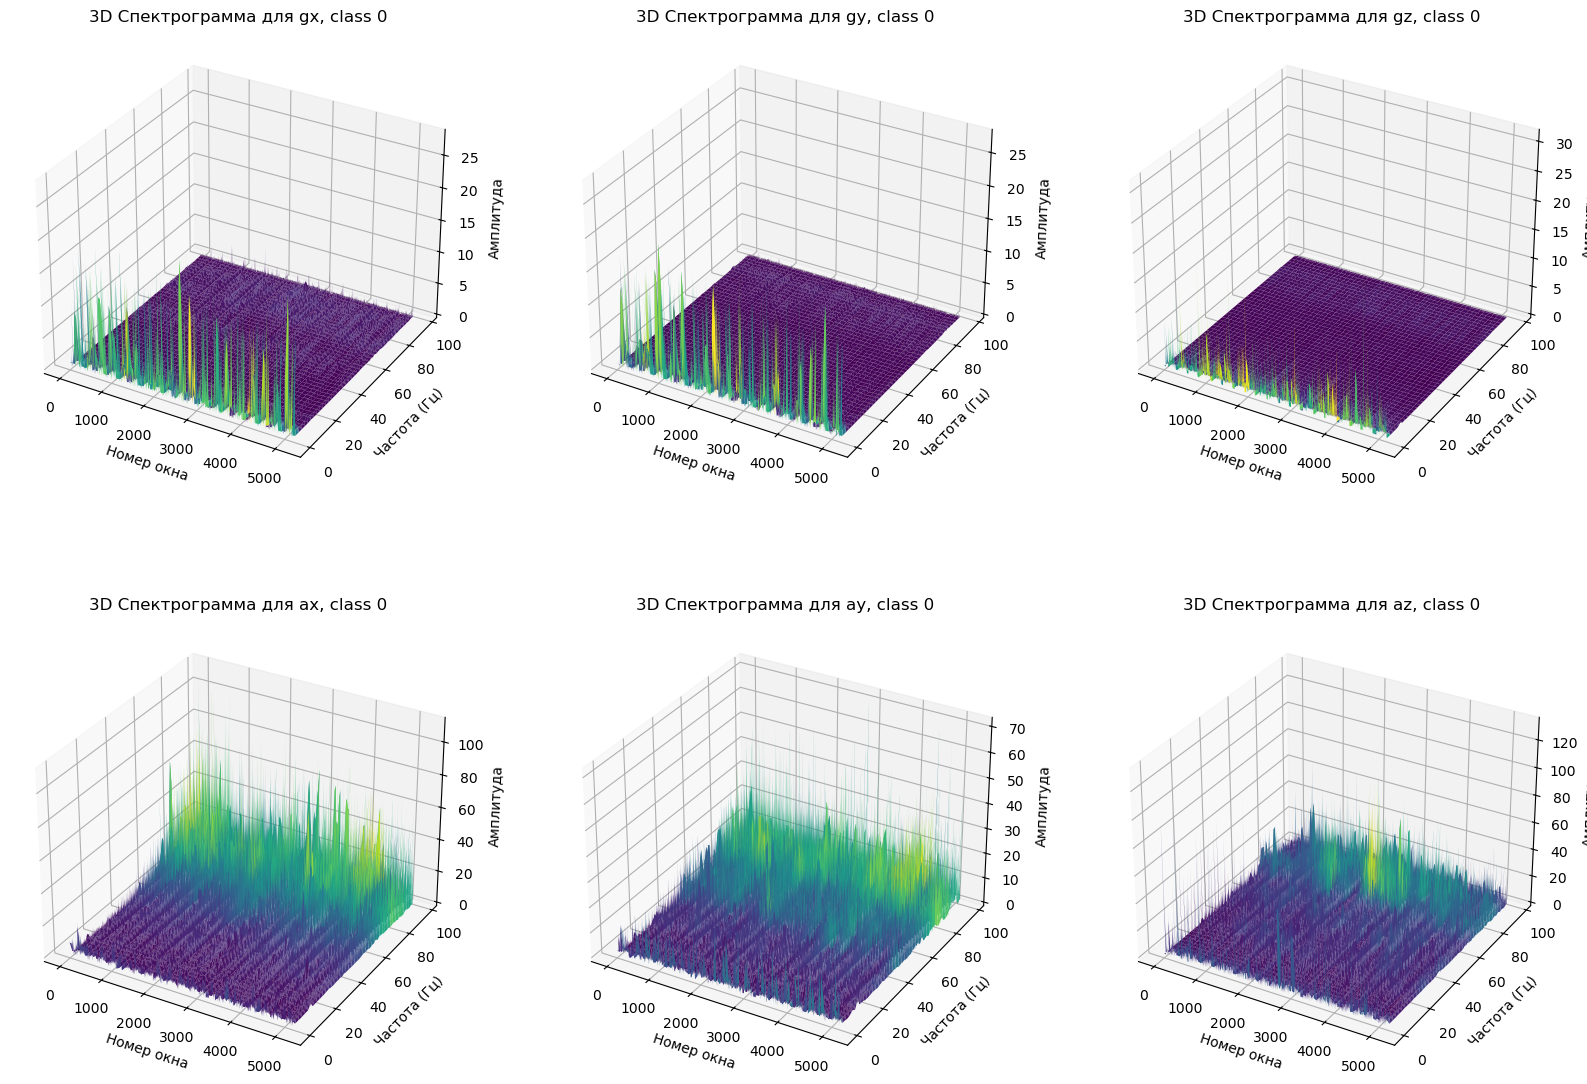

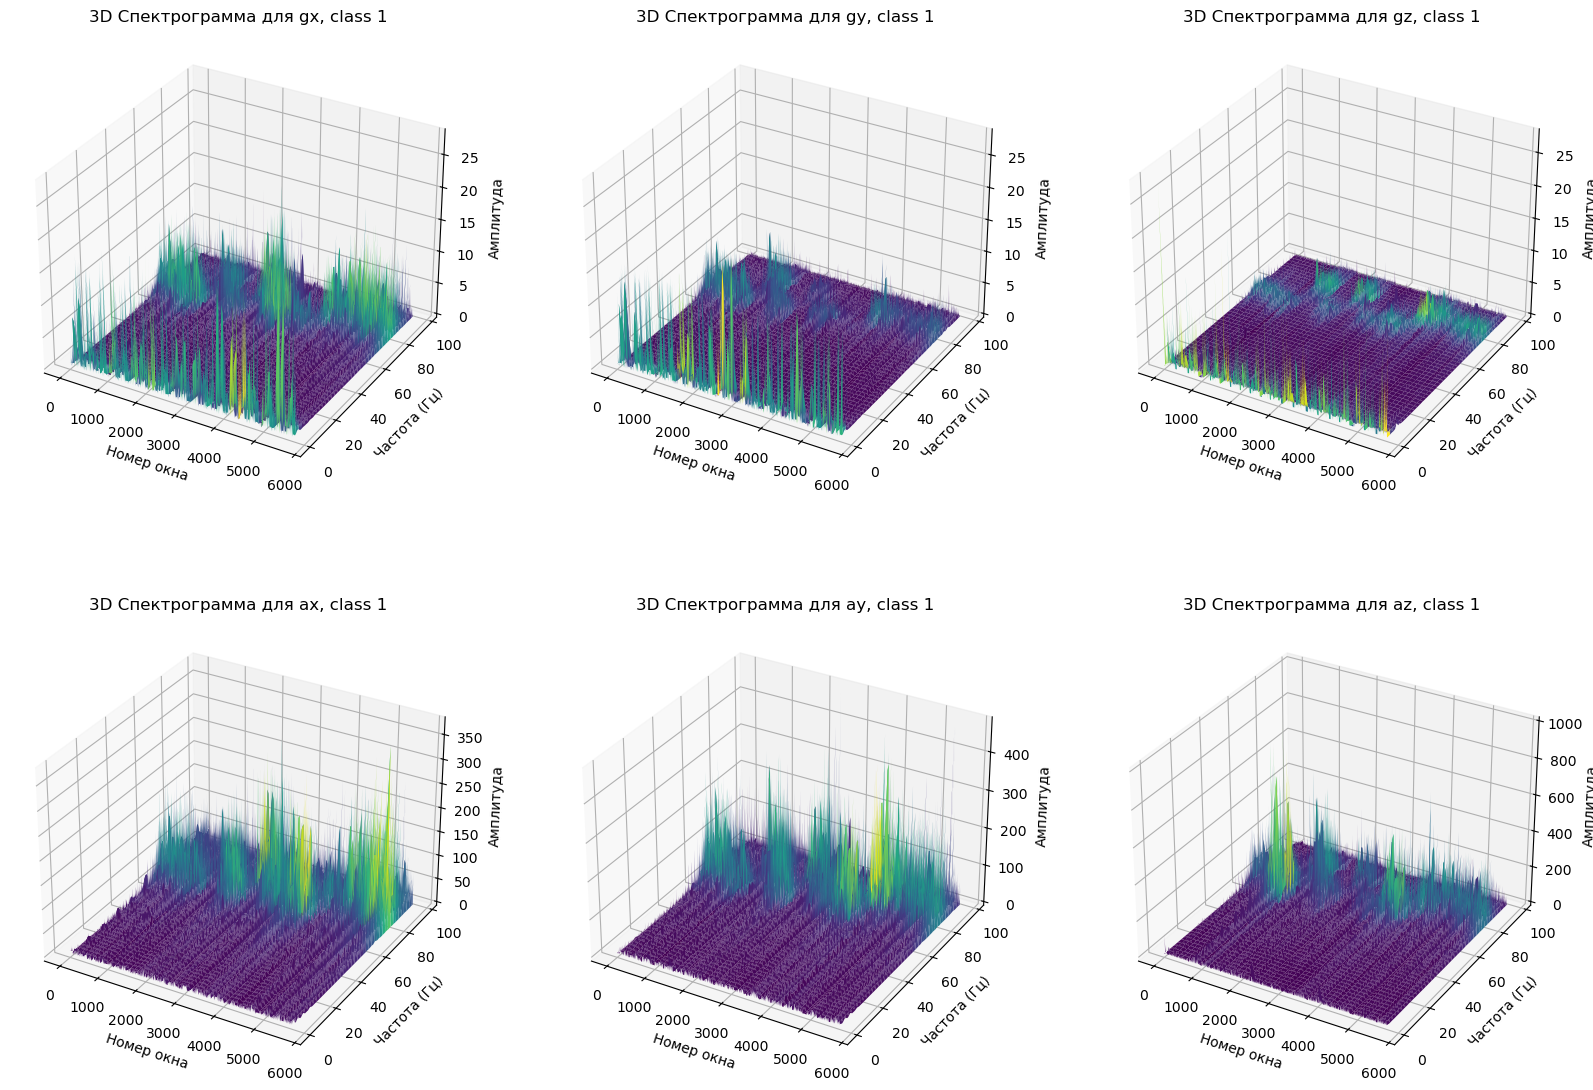

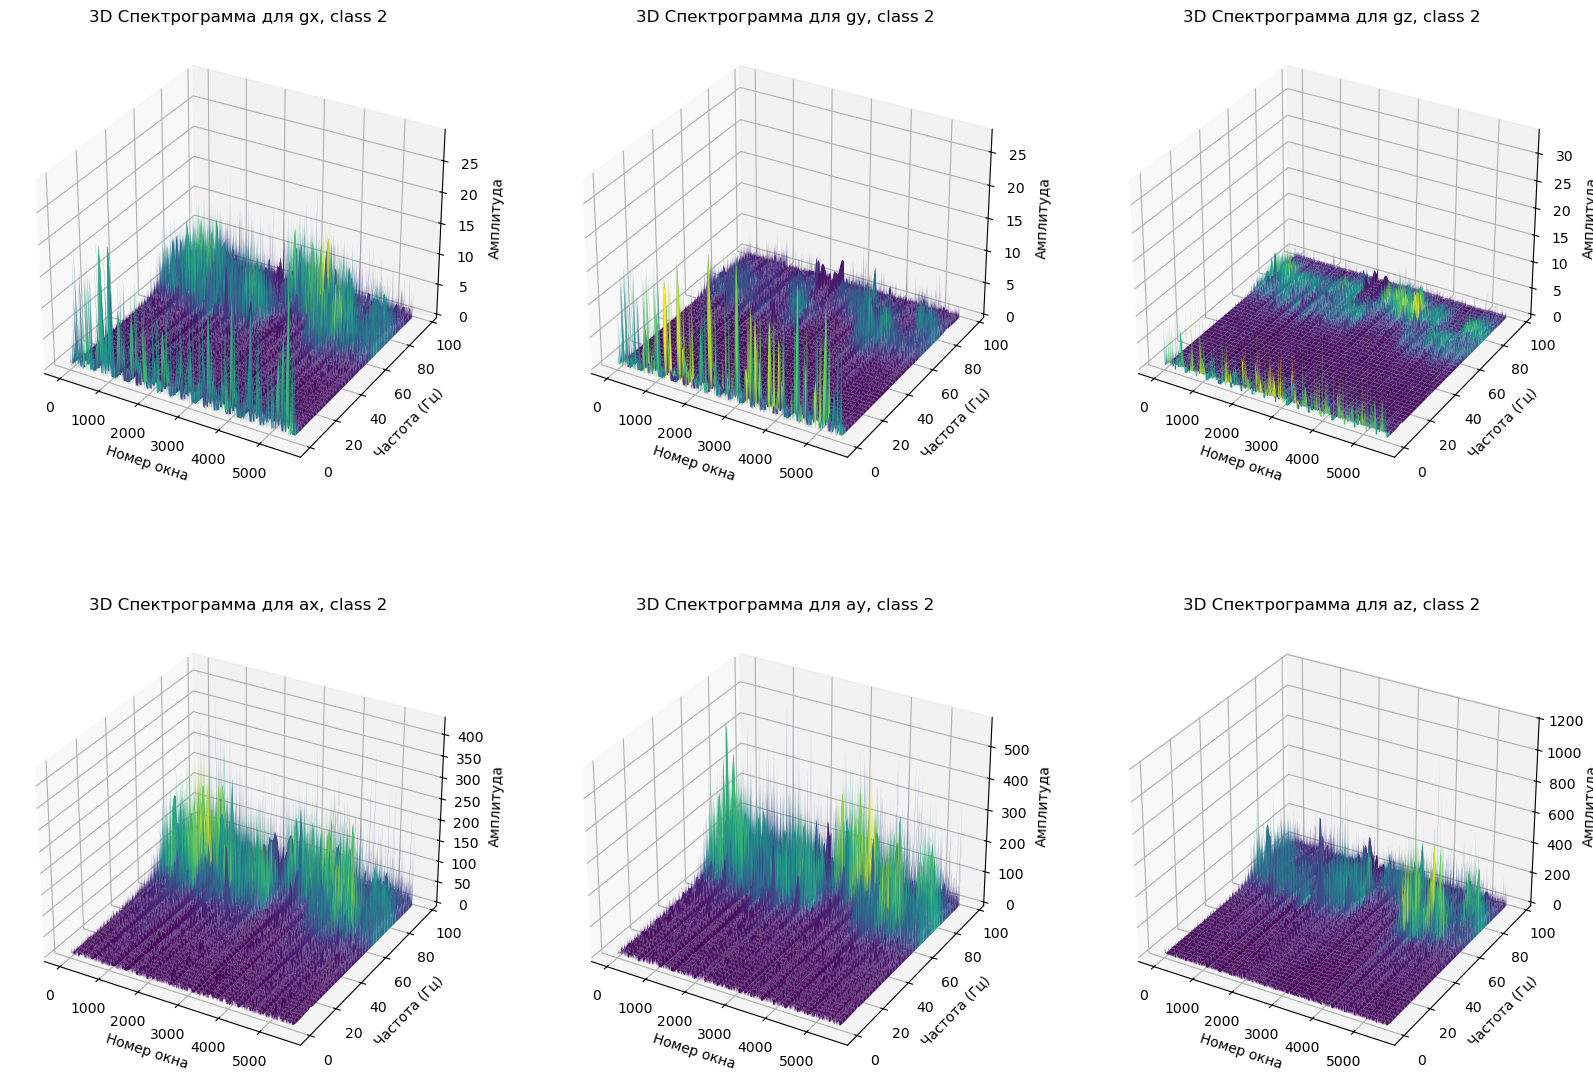

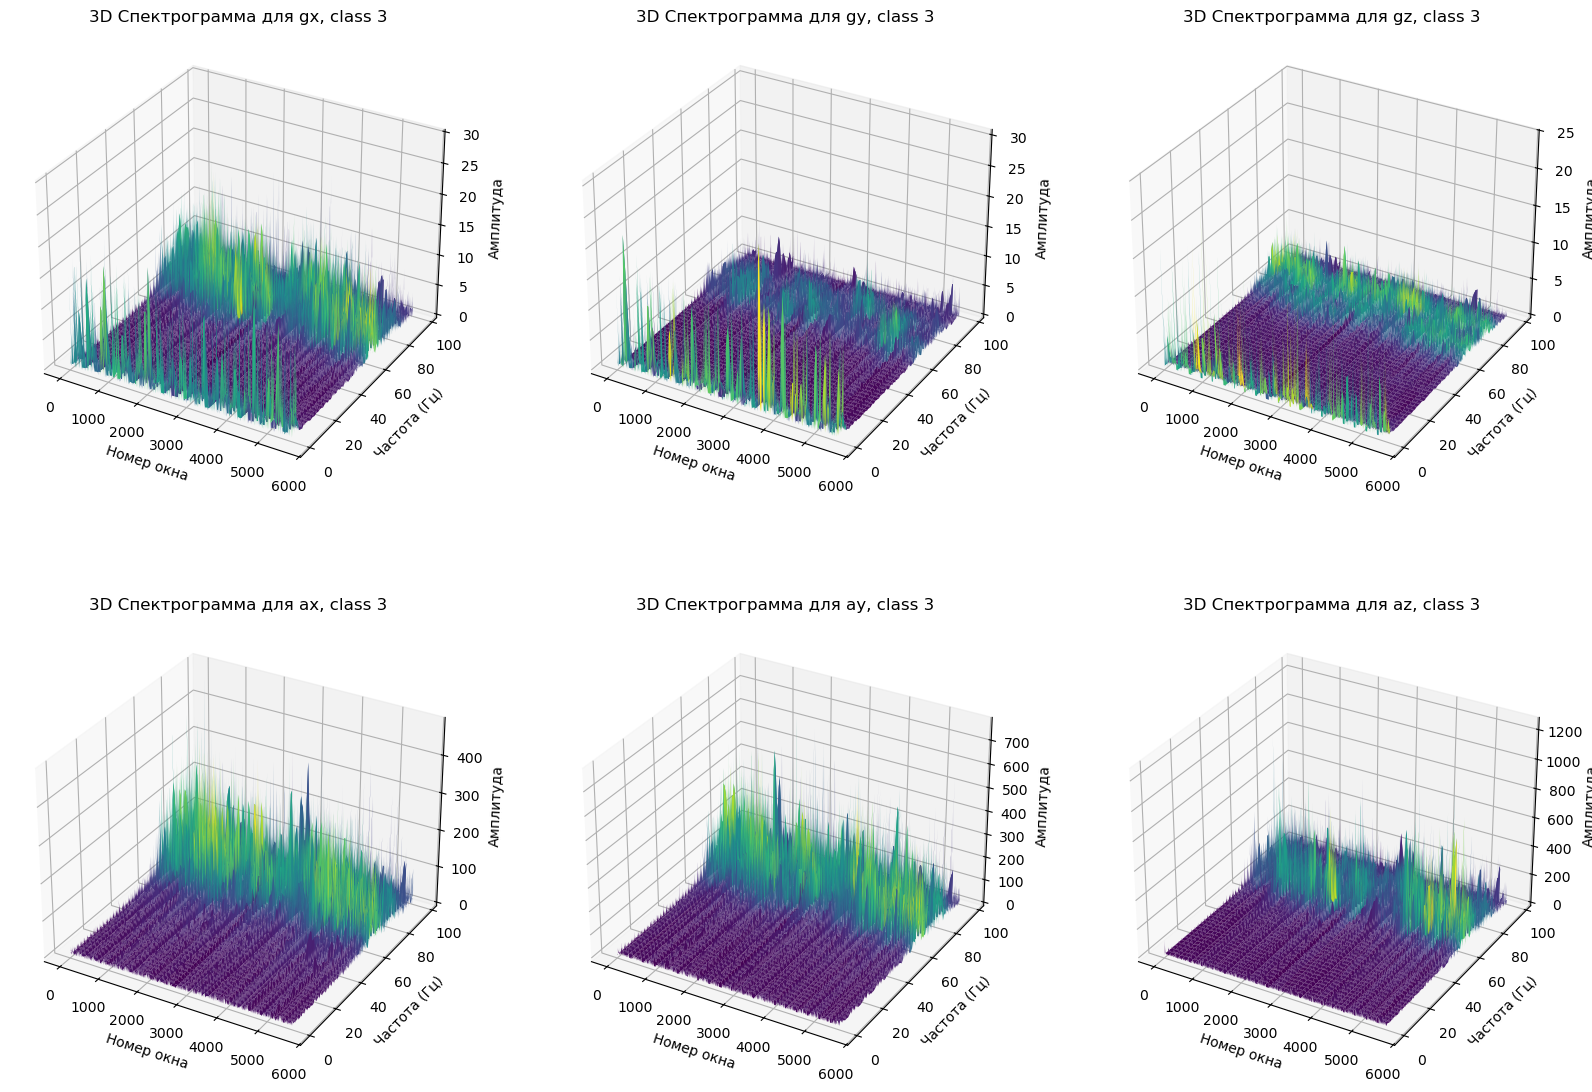

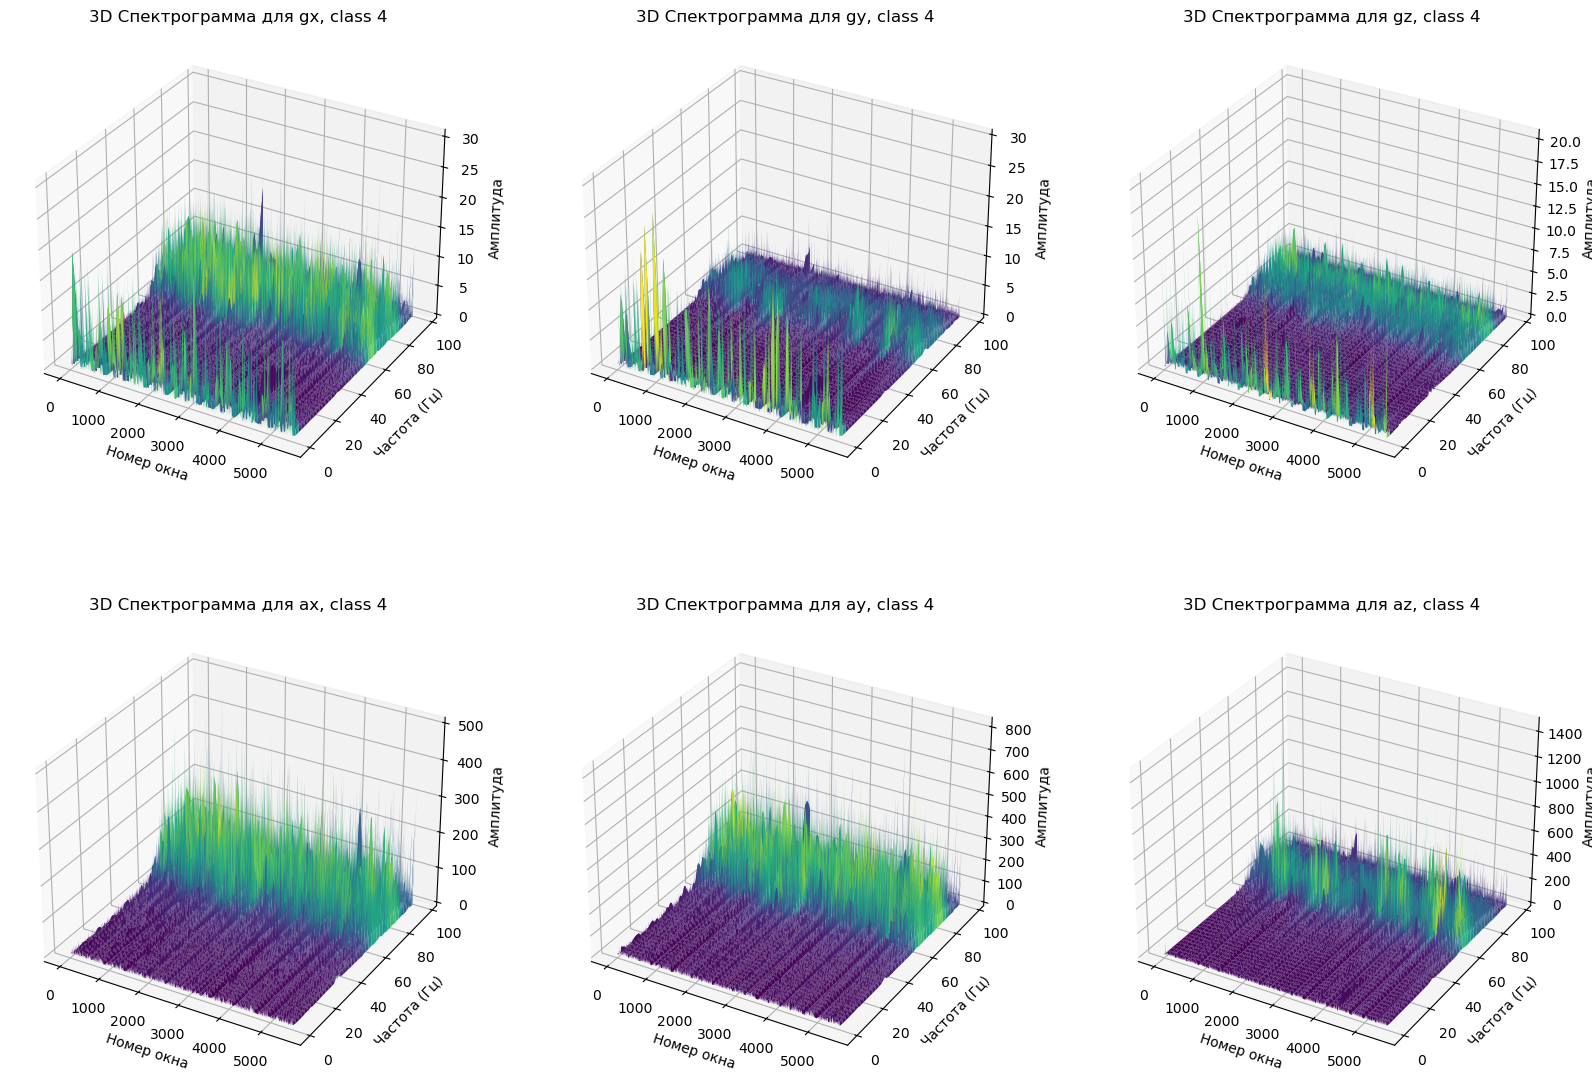

In [7]:
plot_3d_spectrogram(data_dir, Fs, window_size, stride)

## Извлечение признаков

#### Создание названий признаков

In [8]:
# ЧО - частотная область, ВО - временна́я область
cols = []
common_cols = ["Медиана", "Средняя", "Std", "Max", "Min", 
               "90 процентиль", "75 процентиль", "25 процентиль", 
               "Куртозис", "Ассиметрия", "Энергия", "Энергия кв",
               "Сумма модулей", "Размах", "Сумма квадратов", 
               "Макс Кум Сум", "Вариация", "Количество пиков"]

time_cols = ["Общая мощность", "Средняя мощность"]
frequency_cols = ["Средняя > 10 Гц", "Std > 10 Гц", "Энергия > 10 Гц"]

for i in ["mag_g", "mag_a"]:
    for j in ["", "dif_", "dif_dif_"]:
        for k in common_cols + time_cols:
            cols.append(f"{i} {j}ВО {k}")

for i in ["gx", "gy", "gz", "ax", "ay", "az"]:
    for j in ["", "dif_", "dif_dif_"]:
        for k in ["ЧО", "ВО"]:
            if k == "ЧО":
                for u in common_cols + frequency_cols:
                    cols.append(f"{i} {j}{k} {u}")
            else:
                for u in common_cols + time_cols:
                    cols.append(f"{i} {j}{k} {u}")
                    
num_of_features = len(cols)

cols.append("Класс")
features_df = pd.DataFrame(columns=cols)

print(f"Количество признаков: {num_of_features}")

Количество признаков: 858


#### Инициализация функций для извлечения признаков

In [9]:
def common(seg, features):
    median_seg = np.median(seg)
    mean_seg = np.mean(seg)
    std_seg = np.std(seg)
    
    features.append(median_seg)              # Медиана
    features.append(mean_seg)                # Средняя амплитуда
    features.append(std_seg)                 # Стандартное отклонение
    features.append(np.max(seg))             # Максимальная амплитуда
    features.append(np.min(seg))             # Минимальная амплитуда
    features.append(np.percentile(seg, 90))  # 90-й процентиль
    features.append(np.percentile(seg, 75))  # 75-й процентиль
    features.append(np.percentile(seg, 25))  # 25-й процентиль
    features.append(kurtosis(seg))           # Куртозис
    features.append(skew(seg))               # Ассиметрия
    features.append(np.trapz(seg))           # Энергия

    features.append(np.trapz(seg**2))        # Энергия (квадрат)
    features.append(np.sum(np.abs(seg)))     # Сумма модулей
    features.append(np.ptp(seg))             # Размах
    features.append(np.sum(seg**2))          # Сумма квадратов
    features.append(np.max(np.cumsum(seg)))  # МаксКумСум
    
    # Коэффициент вариации
    features.append(std_seg / mean_seg)  
    
    # Количество пиков (выбросов)
    features.append(np.sum(seg > median_seg + 0.5 * std_seg))
    return features


def time_zone(seg, features, fs=200, window_size=256, overlap=128):
    features = common(seg, features)    
    
    # Плотность мощности
    f, Pxx = welch(seg, fs=Fs, window='hann', nperseg=window_size, noverlap=overlap)  
    features.append(np.sum(Pxx[:overlap]))   # Общая мощность
    features.append(np.mean(Pxx[:overlap]))  # Средняя мощность
    return features


def herz_zone(seg, features, more10hz=round(256 / 200 * 10)):
    features = common(seg, features)    

    # Исследование частот > 10 Гц
    amp_half_10 = seg[more10hz:]
    features.append(np.mean(amp_half_10))        # Средняя амплитуда частот > 10 Гц
    features.append(np.std(amp_half_10))         # Стандартное отклонение частот > 10 Гц
    features.append(np.trapz(amp_half_10 ** 2))  # Энергия частот > 10 Гц (квадрат)
    return features

#### Извлечение признаков

In [ ]:
channels = ["gx", "gy", "gz", "ax", "ay", "az"]

window = blackman(window_size)                     # Окно Блэкмана-Наталла для уменьшения утечки спектра
more10hz = round(window_size / Fs * 10)            # Индекс для частот более 10 Гц
frequencies = np.fft.fftfreq(window_size, 1 / Fs)  # Получение частот для спектра

class_folders = os.listdir(f"{data_dir}") 

for _, class_label in zip(trange(len(class_folders), desc='Progress', colour='blue'), class_folders):
    folder_path = os.path.join(data_dir, class_label)   
    file_names = [name for name in os.listdir(folder_path) if "merged" not in name and name.endswith('.csv')]
    
    for _, file_name in zip(trange(len(file_names), desc='Progress', colour='green'), file_names):
        file_path = os.path.join(folder_path, file_name)

        # Загрузка данных из CSV-файла и извлечение значений гироскопа и акселерометра
        df = pd.read_csv(file_path)
        data = df[channels].values  

        # Скользящее окно по даннымс заданным шагом
        for start in range(0, len(data) - window_size + 1, stride):
            segment = data[start:start + window_size]
            segment_windowed = segment * window[:, None]  # Наложение окна
            
            yf = np.fft.fft(segment_windowed, axis=0)     # Применение БПФ
            amplitude = np.abs(yf)                        # Извлечение амплитуд; shape = (num_windows, window_size, 6)
            
            features = []

            # Извлечение признаков из магнитуд гироскопа и акселерометра, их производных и производных их производных
            mag_g = np.sqrt(segment[:, 0]**2 + segment[:, 1]**2 + segment[:, 2]**2)
            mag_a = np.sqrt(segment[:, 3]**2 + segment[:, 4]**2 + segment[:, 5]**2)

            # Первые производные магнитуд
            diff_mag_g = np.diff(mag_g)
            diff_diff_mag_g = np.diff(diff_mag_g)

            # Вторые производные магнитуд
            diff_mag_a = np.diff(mag_a)
            diff_diff_mag_a = np.diff(diff_mag_a)

            # Извлечение временных признаков из всех данных магнитуд
            for seg in [mag_g, diff_mag_g, diff_diff_mag_g, mag_a, diff_mag_a, diff_diff_mag_a]:
                features = time_zone(seg, features)

            # Извлечение признаков из каждой оси гироскопа и акселерометра, их производных и производных их производных
            for channel in range(amplitude.shape[1]):
                amp_half = amplitude[:stride, channel]  # Берем только положительные частоты 
                
                diff_amp_half = np.diff(amp_half)            # Первая производная амплитуд спектра
                diff_diff_amp_half = np.diff(diff_amp_half)  # Вторая производная амплитуд спектра
                
                seg = segment[:, channel]                     
                diff_seg = np.diff(seg)                      # Первая производная временных данных
                diff_diff_seg = np.diff(diff_seg)            # Вторая производная временных данных

                # Обработка исходных данных и их производных
                for amp_half_i, seg_i in [[amp_half, seg], [diff_amp_half, diff_seg], [diff_diff_amp_half, diff_diff_seg]]:
                    
                    features = herz_zone(amp_half_i, features)  # Извлечение частотных признаков
                    features = time_zone(seg_i, features)       # Извлечение временных признаков
    
            # Добавляем метку класса и сохраняем извлеченные признаки
            features.append(class_label)
            features_df.loc[len(features_df)] = features

percent_stride = int(p) if (p := round((1 - stride / window_size) * 100, 3)) == int(p) else p

features_file_name = f"features_{data_dir.lower()}_ws{window_size}_str{percent_stride}.csv"
features_df.to_csv(features_file_name, index=False)             

## Построение, обучение и сравнение моделей

#### Функции для препроцессинга данных

In [27]:
def transform_data(scaler, X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return scaler, X_train, X_test


def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)


def preprocess_pipeline(features_df, test_size=0.2, random_state=42, scalers=True, pwTr=False, stSc=False, mnMx=False, save_scalers=False, to_categorical_y=False):
    # Разбиение данных на признаки и целевую переменную
    X = features_df.drop(columns=["Класс"])
    y = features_df["Класс"].values

    if to_categorical_y:
        y = to_categorical(y)
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    
    # Приведение к нормальному распределению (Преобразование Yeo-Johnson)
    if scalers or pwTr:
        power_transformer = PowerTransformer(method='yeo-johnson')
        power_transformer, X_train, X_test = transform_data(power_transformer, X_train, X_test)
        if save_scalers:
            save_pickle(power_transformer, 'power_transformer.pkl')
        
    # Стандартизация данных    
    if save_scalers or stSc:
        standard_scaler = StandardScaler()
        standard_scaler, X_train, X_test = transform_data(standard_scaler, X_train, X_test)
        if save_scalers:
            save_pickle(standard_scaler, 'standard_scaler.pkl')
                
    # Нормализация данных
    if save_scalers or mnMx:       
        minmax_scaler = MinMaxScaler()
        minmax_scaler, X_train, X_test = transform_data(minmax_scaler, X_train, X_test)
        if save_scalers:
            save_pickle(minmax_scaler, 'minmax_scaler.pkl')
                
    return X_train, X_test, y_train, y_test

In [11]:
# Загрузка данных
features_file_name = f"features_{data_dir.lower()}_ws256_str75.csv"
# Настройки
data_dir = "Data_Real" # "Data_Real", "Data_MatLab"
window_size = 256
stride = 64

Fs = 195 if data_dir == "Data_Real" else 200

features_df = pd.read_csv(features_file_name)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = preprocess_pipeline(features_df)

#### Инциализация, обучение и тестирование моделей

In [12]:
random_state = 42

models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance'),
    "Naive Bayes": GaussianNB(var_smoothing=0.1),
    "Support Vector Machine": SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state),
    "Logistic Regression": LogisticRegression(C=300, solver='newton-cg', random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(max_depth=30, criterion='entropy', random_state=random_state),
    "Perceptron": MLPClassifier(hidden_layer_sizes=(144, 256, 64, 16, 5), max_iter=400, random_state=random_state),
    "Random Forest": RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state),
    "CatBoost": CatBoostClassifier(silent=True, random_state=random_state),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6, random_state=random_state), n_estimators=400, learning_rate=0.1),  
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Histogram-based Gradient Boosting": HistGradientBoostingClassifier(random_state=random_state),
    "XGBoost": XGBClassifier(random_state=random_state, device="cuda"),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=random_state),
    
    "Stacking Classifier LR": StackingClassifier(
        estimators=[("LightGBM", LGBMClassifier(verbose=-1, random_state=random_state)),
                    ("Random Forest", RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state)),
                    ("XGBClassifier", XGBClassifier(random_state=random_state)),
                    ("CatBoost", CatBoostClassifier(silent=True, random_state=random_state)),
                    ("Histogram-based Gradient Boosting", HistGradientBoostingClassifier(random_state=random_state)),
                    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance')),
                    ("Support Vector Machine", SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state))
                   ],
        final_estimator=LogisticRegression(random_state=random_state)),

    "Stacking Classifier XGB": StackingClassifier(
        estimators=[("LightGBM", LGBMClassifier(verbose=-1, random_state=random_state)),
                    ("Random Forest", RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state)),
                    ("XGBClassifier", XGBClassifier(random_state=random_state)),
                    ("CatBoost", CatBoostClassifier(silent=True, random_state=random_state)),
                    ("Histogram-based Gradient Boosting", HistGradientBoostingClassifier(random_state=random_state)),
                    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance')),
                    ("Support Vector Machine", SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state))
                   ],
        final_estimator=XGBClassifier(random_state=random_state)),
    
    "Voting Classifier": VotingClassifier(
        estimators=[("LightGBM", LGBMClassifier(verbose=-1, random_state=random_state)),
                    ("Random Forest", RandomForestClassifier(n_estimators=400, max_depth=20, random_state=random_state)),
                    ("XGBClassifier", XGBClassifier(random_state=random_state)),
                    ("CatBoost", CatBoostClassifier(silent=True, random_state=random_state)),
                    ("Histogram-based Gradient Boosting", HistGradientBoostingClassifier(random_state=random_state)),
                    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=1, metric='manhattan', weights='distance')),
                    ("Support Vector Machine", SVC(C=800, gamma=0.1, class_weight='balanced', tol=0.01, probability=True, random_state=random_state)),
                    ("Logistic Regression", LogisticRegression(C=300, solver='newton-cg', random_state=random_state)),
                    ("Perceptron", MLPClassifier(hidden_layer_sizes=(144, 256, 64, 16, 5), max_iter=400, random_state=random_state))
                   ], 
        voting='soft')
}

# Обучение и тестирование моделей
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)} %\n", )
    print("-" * 53)


K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1037
           1       0.97      0.99      0.98      1145
           2       0.96      0.96      0.96      1113
           3       0.95      0.94      0.94      1125
           4       0.97      0.96      0.96      1108

    accuracy                           0.97      5528
   macro avg       0.97      0.97      0.97      5528
weighted avg       0.97      0.97      0.97      5528

Accuracy: 96.74 %

-----------------------------------------------------

Naive Bayes:

              precision    recall  f1-score   support

           0       0.62      0.99      0.76      1037
           1       0.96      0.79      0.87      1145
           2       0.83      0.57      0.68      1113
           3       0.64      0.60      0.62      1125
           4       0.73      0.73      0.73      1108

    accuracy                           0.73      5528
   macro avg       0

## Сравнение обученных моделей

#### Сравнение моделей по метрике точности accuracy

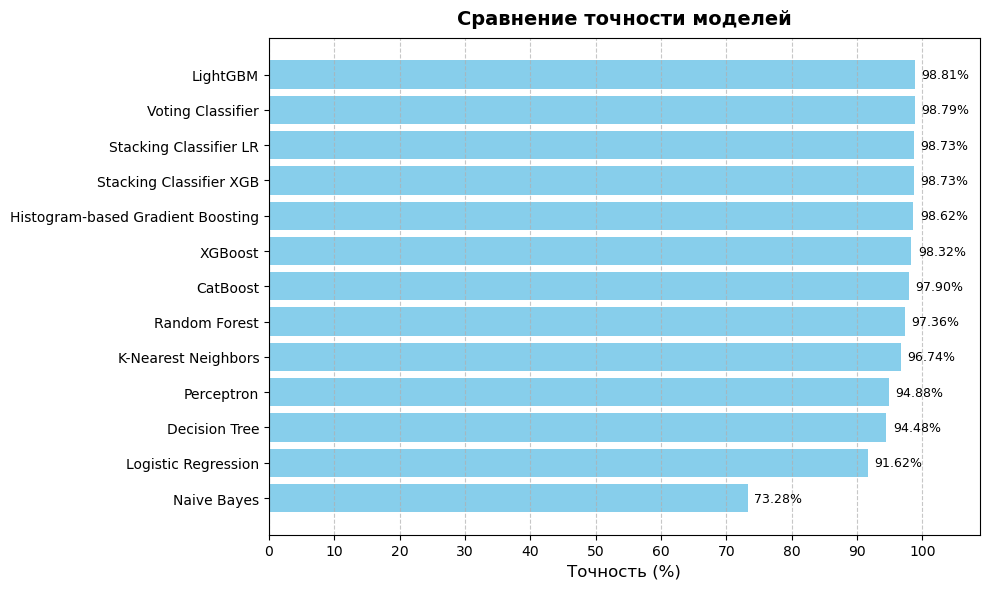

In [16]:
models_accuracy_dict = {}
for name, model in models.items():
    accuracy = accuracy_score(y_test, model.predict(X_test))
    models_accuracy_dict[name] = round(accuracy * 100, 3)

models_accuracy_df = pd.DataFrame({
    'Модель': models_accuracy_dict.keys(),
    'Точность': models_accuracy_dict.values()
}).sort_values(by='Точность', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(models_accuracy_df['Модель'], models_accuracy_df['Точность'], color='skyblue')

plt.xticks(np.arange(0, 101, 10))

max_width = models_accuracy_df['Точность'].max()
plt.xlim(0, max_width + 10)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             ha='left', va='center', fontsize=9)

plt.xlabel('Точность (%)', fontsize=12, fontweight='medium')
plt.title('Сравнение точности моделей', fontsize=14, fontweight='demibold', pad=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()

plt.tight_layout()
# plt.savefig('models_accuracy_comparison.png', dpi=1200, bbox_inches='tight')
plt.show()

#### Оценка моделей по четырем метрикам точности

In [14]:
models_acc_dict = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    models_acc_dict[name] = {
        'Accuracy': round(accuracy * 100, 3),
        'Precision': round(precision * 100, 3),
        'Recall': round(recall * 100, 3),
        'F1 Score': round(f1 * 100, 3),
    }

models_acc_df = pd.DataFrame(models_acc_dict).T
models_acc_df = models_acc_df.sort_values(by='Accuracy', ascending=False)
models_acc_df

Accuracy  Precision  Recall  F1 Score
LightGBM                             98.806     98.806  98.806    98.806
Voting Classifier                    98.788     98.788  98.788    98.788
Stacking Classifier LR               98.734     98.734  98.734    98.734
Stacking Classifier XGB              98.734     98.735  98.734    98.734
Histogram-based Gradient Boosting    98.625     98.628  98.625    98.626
XGBoost                              98.318     98.317  98.318    98.317
CatBoost                             97.902     97.898  97.902    97.899
Random Forest                        97.359     97.355  97.359    97.356
K-Nearest Neighbors                  96.744     96.738  96.744    96.738
Perceptron                           94.881     94.879  94.881    94.874
Decision Tree                        94.483     94.472  94.483    94.476
Logistic Regression                  91.624     91.608  91.624    91.613
Naive Bayes                          73.281     75.809  73.281    73.122

#### Построение матрицы ошибок для Stacking Classifier

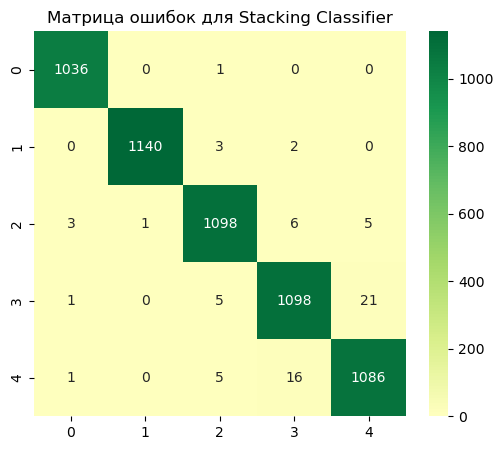

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, models.get("Stacking Classifier LR").predict(X_test)), 
            annot=True, 
            cmap=sns.color_palette("RdYlGn", n_colors=1000), 
            center=0, 
            fmt='d')

plt.title('Матрица ошибок для Stacking Classifier')
# plt.savefig('stacking_сlassifier_confusion_matrix.png', dpi=1200, bbox_inches='tight')
plt.show()

#### Построение ROC-кривой для Stacking Classifier

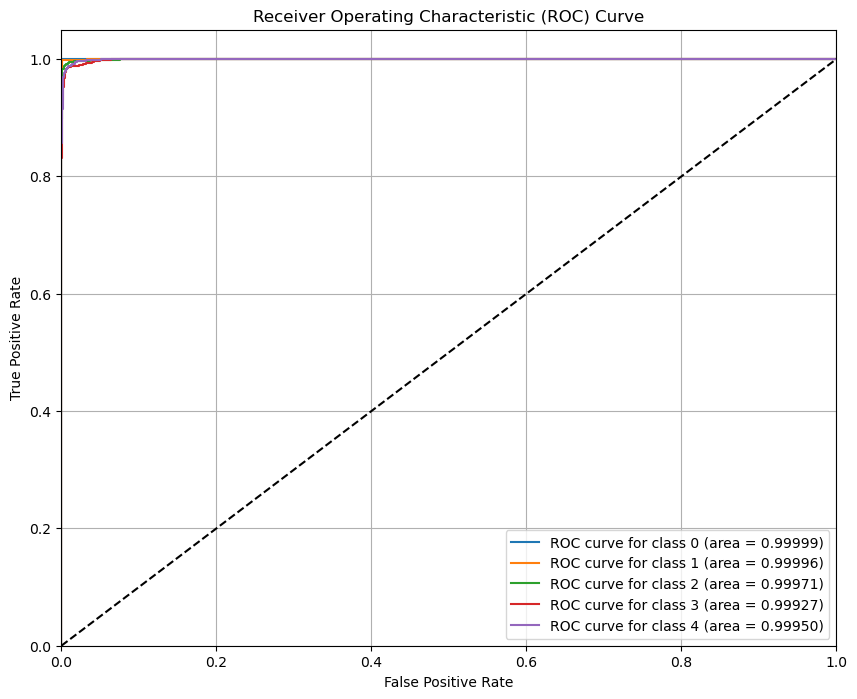

In [19]:
voting_model = models["Stacking Classifier LR"]
y_score = voting_model.predict_proba(X_test)
classes = np.unique(y_test)

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test, y_score[:, i], pos_label=classes[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
# plt.savefig('stacking_classifier_roc_curve.png', dpi=1200, bbox_inches='tight')
plt.show()

#### Построение матрицы ошибок для XGBoost

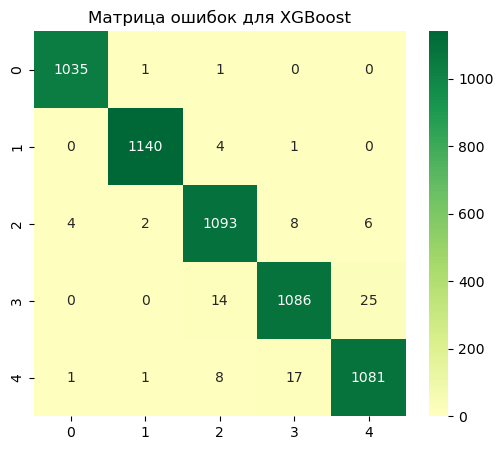

In [20]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, models.get("XGBoost").predict(X_test)), 
            annot=True, 
            cmap=sns.color_palette("RdYlGn", n_colors=1000), 
            center=0, 
            fmt='d')

plt.title('Матрица ошибок для XGBoost')
# plt.savefig('XGBoost_confusion_matrix.png', dpi=1200, bbox_inches='tight')
plt.show()

#### Построение ROC-кривой для XGBoost

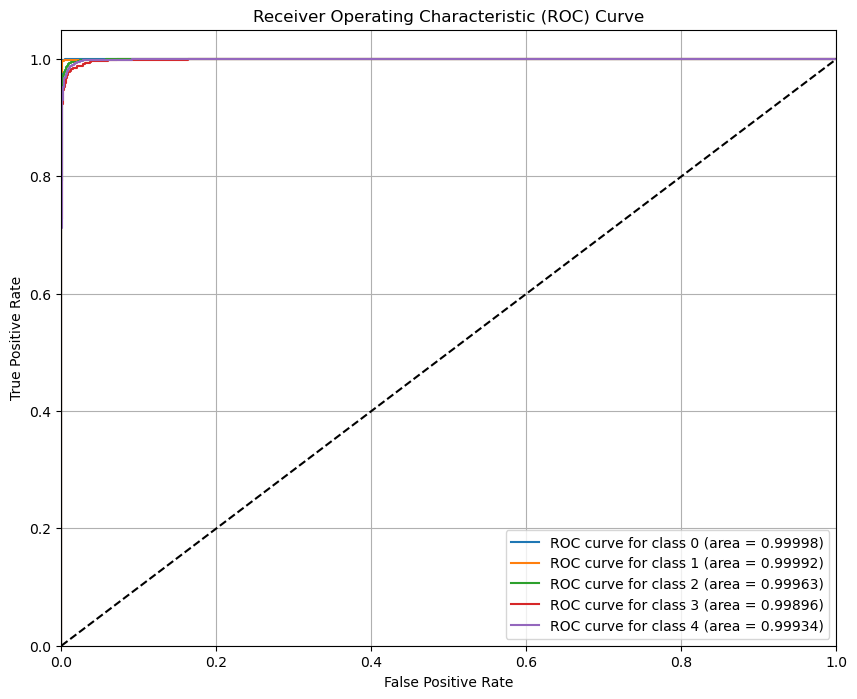

In [21]:
voting_model = models["XGBoost"]
y_score = voting_model.predict_proba(X_test)
classes = np.unique(y_test)

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test, y_score[:, i], pos_label=classes[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
# plt.savefig('stacking_classifier_roc_curve.png', dpi=1200, bbox_inches='tight')
plt.show()

#### Пример использования GridSearchCV для поиска оптимальных параметров

In [ ]:
param_grid = {
    'n_neighbors': [1, 3, 7, 15],
    'leaf_size': [1, 2, 3],
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)
print("Лучшая оценка перекрестной проверки: ", grid_search.best_score_)

## Создание, обучение и тестирование нейронной сети

In [28]:
np.random.seed(random_state)
tf.random.set_seed(random_state)

features_df = pd.read_csv(features_file_name)
X_train, X_test, y_train, y_test = preprocess_pipeline(features_df, scalers=False, mnMx=True, to_categorical_y=True)

model = Sequential()
model.add(Dense(1024, input_shape=(858,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Архитектура нейронной сети
model.summary()

trained_model = model.fit(X_train, y_train, epochs=600, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 1024)                │         879,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,552,517 (5.92 MB)

 Trainable params: 1,552,517 (5.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7403 - loss: 0.6173 - val_accuracy: 0.8397 - val_loss: 0.3694
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8069 - loss: 0.4493 - val_accuracy: 0.8426 - val_loss: 0.3562
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8294 - loss: 0.3966 - val_accuracy: 0.8507 - val_loss: 0.3405
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8298 - loss: 0.3994 - val_accuracy: 0.8428 - val_loss: 0.3596
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8345 - loss: 0.3793 - val_accuracy: 0.8555 - val_loss: 0.3310
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8381 - loss: 0.3787 - val_accuracy: 0.8299 - val_loss: 0.3970
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8436 - loss: 0.3621 - val_accuracy: 0.8464 - val_loss: 0.3404
Epoch 8/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8502 -

#### Оценка нейронной сети по четырем метрикам точности

In [29]:
print(classification_report(y_true, y_pred_classes))
print(f" Accuracy: {round(accuracy_score(y_true, y_pred_classes) * 100, 2)} %")
print(f"Precision: {round(precision_score(y_true, y_pred_classes, average='weighted') * 100, 2)} %")
print(f" F1-Score: {round(f1_score(y_true, y_pred_classes, average='weighted') * 100, 2)} %")
print(f"   Recall: {round(recall_score(y_true, y_pred_classes, average='weighted') * 100, 2)} %")

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1037
           1       0.99      0.86      0.92      1145
           2       0.64      0.95      0.77      1113
           3       0.91      0.82      0.86      1125
           4       0.96      0.84      0.90      1108

    accuracy                           0.87      5528
   macro avg       0.90      0.87      0.88      5528
weighted avg       0.90      0.87      0.88      5528

 Accuracy: 86.87 %
Precision: 90.01 %
 F1-Score: 87.53 %
   Recall: 86.87 %


#### Построение графиков точности и потерь на обучающей и валидационной выборках по эпохам

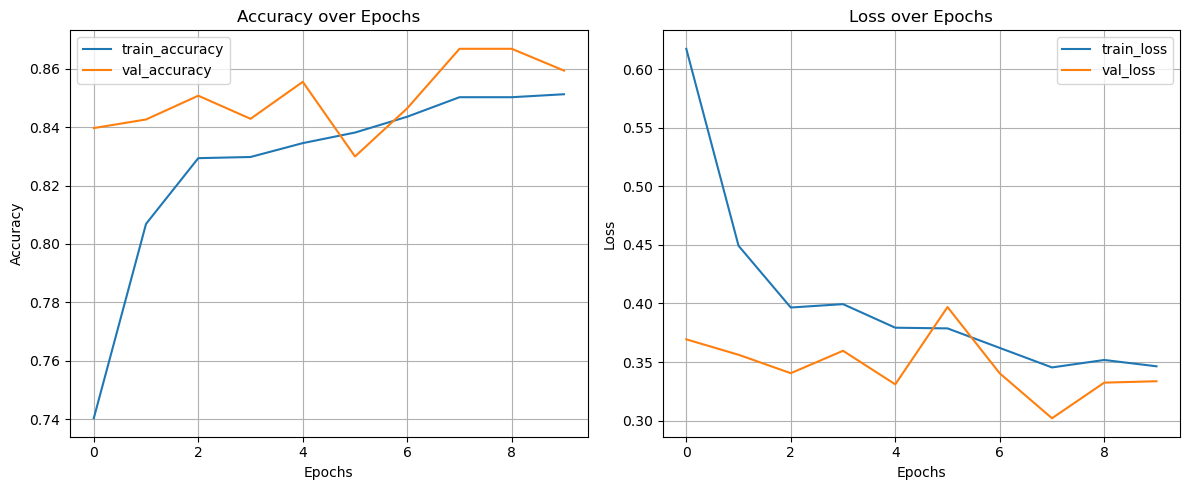

In [56]:
plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(trained_model.history['accuracy'], label='train_accuracy')
plt.plot(trained_model.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(trained_model.history['loss'], label='train_loss')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
# plt.savefig('neural_network_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

#### Построение матрицы ошибок для нейронной сети

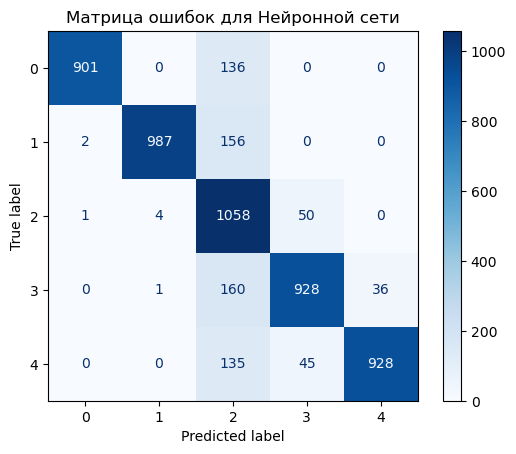

In [32]:
confMat = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred_classes), display_labels=np.arange(5))
confMat.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок для Нейронной сети')
# plt.savefig('neural_network_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Исследование влияния признаков, сохранившихся после удаления избыточных по заданным порогам корреляции, на точность модели.

#### Вычисление предварительной важности признаков

In [33]:
# Загрузка данных
features_df = pd.read_csv(features_file_name)
features_df_without_classes = features_df.drop(columns=["Класс"])

n_iter = 100
feature_importances = np.zeros(num_of_features)

for i in range(n_iter):
    # Получение тренировочных и тестовых данных
    X_train, X_test, y_train, y_test = preprocess_pipeline(features_df, random_state=i)
    
    # Обучение XGBoost для получения важности признаков
    model = XGBClassifier(random_state=i, device="cuda")
    model.fit(X_train, y_train)
    
    feature_importances += model.feature_importances_
    
# Нормализация и сортировка
mean_importance = feature_importances / n_iter
importance_df = pd.DataFrame({
    'Importance': mean_importance
    }, index=features_df_without_classes.columns
    ).sort_values('Importance', ascending=False)

importance_df.to_csv(f"feature_importances_xgb_mean_of_iter{n_iter}.csv")

#### Удаление избыточных по заданным порогам корреляции признаков

In [34]:
# Загрузка данных
features_df = pd.read_csv(features_file_name)
features_df_without_classes = features_df.drop(columns=["Класс"])
importance_df = pd.read_csv(f"feature_importances_xgb_mean_of_iter{n_iter}.csv", index_col=0)

# Расчет корреляции
correlation_matrix = features_df_without_classes.corr(method='spearman')

# Пороги корреляции
thresholds = [0.8, 0.85, 0.9, 0.95, 0.98, 1]

# Создаем папку для результатов
os.makedirs('Reduced_features', exist_ok=True)

for threshold in thresholds:
    # Фильтрация пар с высокой корреляцией (исключая диагональ)
    high_corr = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)
    
    # Преобразование матрицы в таблицу пар
    high_corr_pairs = correlation_matrix[high_corr].stack().reset_index()
    high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    
    # Удаление дубликатов пар (A-B и B-A → останется только A-B)
    high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature_1'] < high_corr_pairs['Feature_2']]
    
    # Удаление коррелированных признаков (оставляем более важные)
    to_drop = set()
    for _, row in high_corr_pairs.iterrows():
        f1, f2 = row['Feature_1'], row['Feature_2']
        if f1 in importance_df.index and f2 in importance_df.index:
            if importance_df.loc[f1, 'Importance'] > importance_df.loc[f2, 'Importance']:
                to_drop.add(f2)
            else:
                to_drop.add(f1)
    
    df_reduced = features_df.drop(columns=to_drop)
    
    print(f"Порог: {threshold}")
    print(f"Удалено признаков: {len(to_drop)}")
    print(f"Оставлено признаков: {df_reduced.shape[1] - 1}\n")
    
    # Сохранение нового набора данных
    file_name = f"reduced_features_corr_threshold_{threshold}.csv"
    df_reduced.to_csv(rf"Reduced_features\{file_name}", index=False)
    print(f"Результаты для порога корреляции {threshold} сохранены в файл: {file_name}")


Порог: 0.8
Удалено признаков: 619
Оставлено признаков: 239

Результаты для порога корреляции 0.8 сохранены в файл: reduced_features_corr_threshold_0.8.csv
Порог: 0.85
Удалено признаков: 582
Оставлено признаков: 276

Результаты для порога корреляции 0.85 сохранены в файл: reduced_features_corr_threshold_0.85.csv
Порог: 0.9
Удалено признаков: 539
Оставлено признаков: 319

Результаты для порога корреляции 0.9 сохранены в файл: reduced_features_corr_threshold_0.9.csv
Порог: 0.95
Удалено признаков: 484
Оставлено признаков: 374

Результаты для порога корреляции 0.95 сохранены в файл: reduced_features_corr_threshold_0.95.csv
Порог: 0.98
Удалено признаков: 369
Оставлено признаков: 489

Результаты для порога корреляции 0.98 сохранены в файл: reduced_features_corr_threshold_0.98.csv
Порог: 1
Удалено признаков: 0
Оставлено признаков: 858

Результаты для порога корреляции 1 сохранены в файл: reduced_features_corr_threshold_1.csv


#### Подбор и оценка признаков с помощью RFECV для разных порогов корреляции

In [ ]:
# АХТУНГ!!! ВЫПОЛНЯЕТСЯ ДВОЕ СУТОК!!!

# Кастомный JSON энкодер для преобразования NumPy чисел в стандартные Python типы при сериализации в JSON
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        
        if isinstance(obj, np.integer):
            return int(obj)
            
        elif isinstance(obj, np.floating):
            return float(obj)
            
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
            
        return super().default(obj)
        

rfecv_results_list = []

# Создаем папку для результатов
os.makedirs('Rfecv_results', exist_ok=True)

for threshold in thresholds:
    # Загрузка данных
    df = pd.read_csv(rf"Reduced_features\reduced_features_corr_threshold_{threshold}.csv")
    X = df.drop(columns=["Класс"])
    y = df["Класс"].values
        
    # Настройка RFECV
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    
    rfecv = RFECV(
        estimator=XGBClassifier(random_state=42, device="cuda"), 
        step=1, 
        cv=cv, 
        scoring='accuracy', 
        n_jobs=1)  # n_jobs=1 из-за GPU
    
    # Выполнение RFECV
    rfecv.fit(X, y)

    # Сбор полной информации
    result = {
        'threshold': threshold,                                            # Порог корреляции
        'optimal_num_features': rfecv.n_features_,                         # Оптимальное число признаков, найденное RFECV
        'optimal_features': X.columns[rfecv.support_].tolist(),            # Список имен лучших признаков (где rfecv.support_ = True)
        'ranking': rfecv.ranking_.tolist(),                                # Порядок исключения признаков (1 - лучшие)
        'mean_test_score': rfecv.cv_results_['mean_test_score'].tolist(),  # Средняя точность
        'n_features': rfecv.cv_results_['n_features'].tolist()             # Число признаков на каждом шаге
    }

    # Сохранение в общий список
    rfecv_results_list.append(result)

    # Сохранение JSON для текущего threshold
    json_filename = f"Rfecv_results/rfecv_threshold_{threshold}.json"
    with open(json_filename, 'w', encoding='utf-8') as f:
        json.dump(result, f, cls=NumpyEncoder, ensure_ascii=False, indent=2)

    # Вывод информации
    print(f"Результаты для порога корреляции {threshold} сохранены в JSON файл: {json_filename}")
    print(f"Лучшее число признаков для порога корреляции {threshold}: {rfecv.n_features_}")
    print(f"Лучшая accuracy: {max(rfecv.cv_results_['mean_test_score']):.4f}\n")


#### Построение графика точности модели в зависимотси от количества признаков и порогов корреляции

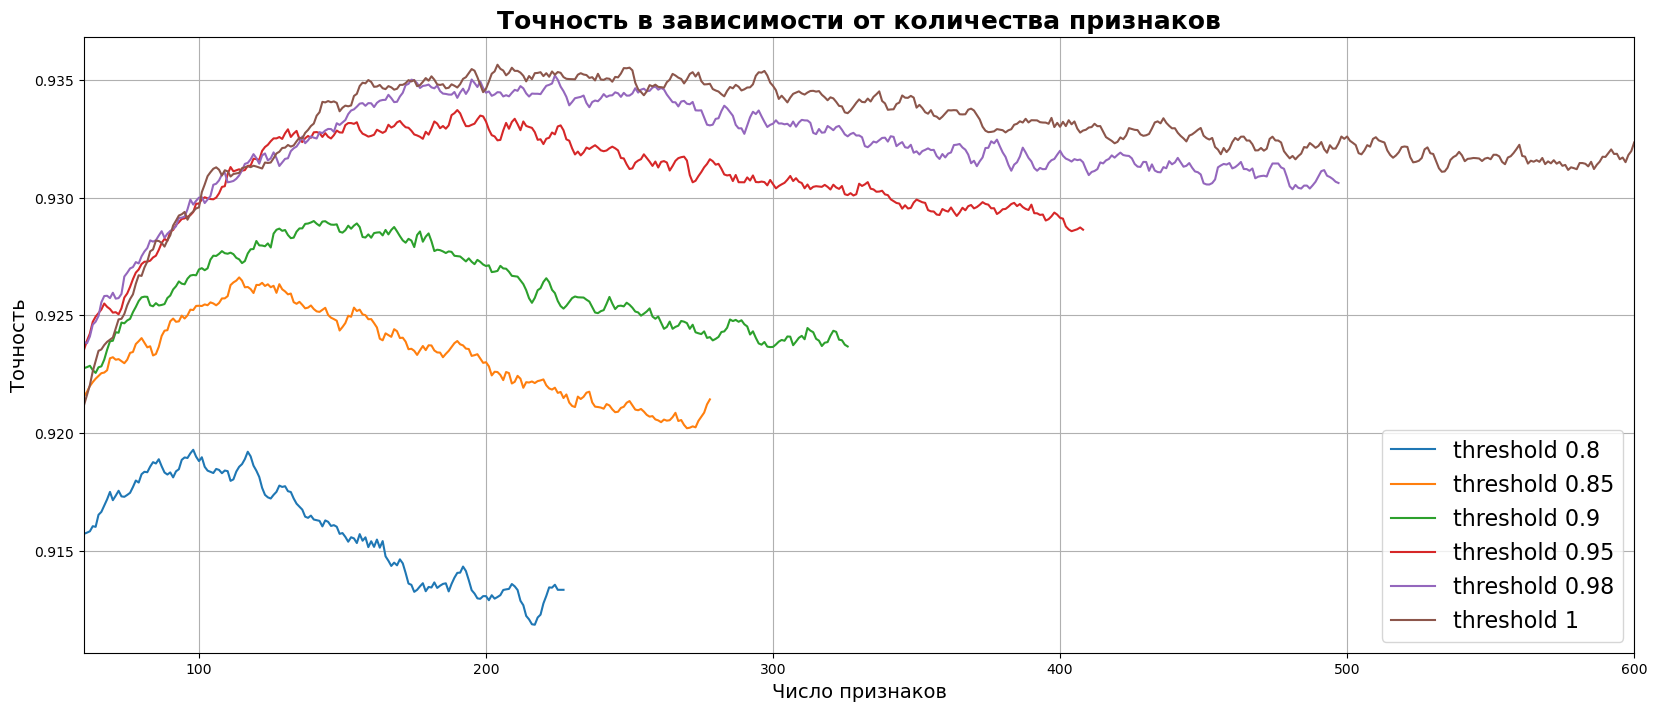

In [38]:
def moving_average(data, median_window_size):
    
    if median_window_size % 2 == 0:
        raise ValueError("Размер окна должен быть нечетным")
    
    data = np.array(data)
    half_window = median_window_size // 2
    
    # Дополнение массива
    padded_data = np.pad(data, (half_window, half_window), mode='edge')

    # Ядро для свертки
    kernel = np.ones(median_window_size) / median_window_size
    
    # Применение свертки
    result = np.convolve(padded_data, kernel, mode='valid')
    
    return result

# Параметры
a = 60   # a э [1;   inf]
b = 600  # b э [a+1; inf]
median_window_size = 5  # Размер окна для сглаживания (должен быть нечётный)

json_file_names = [name for name in os.listdir('Rfecv_results') if "json" in name]
rfecv_results_list = []

for name in json_file_names: 
    with open(rf'Rfecv_results\{name}', 'r', encoding='utf-8') as file:
        rfecv_results_list.append(json.load(file))
        
a = max(1, a)

plt.figure(figsize=(20, 8))
for res, threshold in zip(rfecv_results_list, thresholds):
    new_a = min(len(res['mean_test_score']), a)
    new_b = min(len(res['mean_test_score']), b)
    
    smoothed_res = moving_average(res['mean_test_score'][new_a-1:new_b], median_window_size)
    x_range = range(new_a, new_b+1)
    
    plt.plot(x_range, 
             smoothed_res, 
             label=f'threshold {threshold}')
    
plt.xlim(x_range.start, x_range.stop - 1)

plt.grid()
plt.xlabel("Число признаков",
           fontsize=14, 
           fontweight='medium')

plt.ylabel("Точность",
           fontsize=14, 
           fontweight='medium')

plt.title("Точность в зависимости от количества признаков", 
          fontweight='demibold', 
          fontsize=18)

plt.legend(loc='lower right', fontsize=16)
plt.show()

Из графика выше можно сделать вывод, что уменьшение количества признаков в зависимости от порога корреляции не является целесообразным.

## Создание, обучение и тестирование LSTM нейросети

#### Препроцессинг данных

Проход по папкам классов для разделения .csv файлов с логами полетов на перекрывающиеся сегменты (окна) с заданной длиной, преобразование классов в one-hot и стандартизация + нормализация данных акселерометра и гироскопа.

In [44]:
# Функция для извлечения окон из одного файла
def extract_windows_from_file(file_path, class_label):
    df = pd.read_csv(file_path)
    
    # Извлекаем сырые данные (игнорируем time)
    data = df[['gx', 'gy', 'gz', 'ax', 'ay', 'az']].values  # Shape: (n_timesteps, 6)
    
    # Извлекаем окна с шагом
    windows = []
    labels = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start + window_size]
        windows.append(window)
        labels.append(class_label)
    
    return np.array(windows), np.array(labels)


# Параметры
data_dir = "Data_Real" # "Data_Real", "Data_MatLab"
window_size = 256
stride = 64

class_folders = os.listdir(f"{data_dir}") 
num_classes = len(class_folders)

# Сбор всех данных
all_windows = []
all_labels = []

for clas in class_folders:
    folder_path = os.path.join(data_dir, clas)   
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv') and "data_" not in file_name:

            file_path = os.path.join(folder_path, file_name)
            windows, labels = extract_windows_from_file(file_path, clas)
            
            all_windows.append(windows)
            all_labels.append(labels)


# Объединяем все окна и метки
X = np.concatenate(all_windows, axis=0)  # Shape: (n_samples, 256, 6)
y = np.concatenate(all_labels, axis=0)   # Shape: (n_samples, )
print(f"Общее количество образцов: {X.shape[0]}")

# One-hot encoding для меток (3 класса)
y_onehot = to_categorical(y, num_classes=num_classes)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Нормализация
pipeline = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

X_train_reshaped = X_train.reshape(-1, 6)  # Разворачиваем для нормализации
X_train = pipeline.fit_transform(X_train_reshaped).reshape(X_train.shape)  

X_test_reshaped = X_test.reshape(-1, 6)
X_test = pipeline.transform(X_test_reshaped).reshape(X_test.shape)

print(f"Train shape: {X_train.shape} \nTest shape: {X_test.shape}")

Общее количество образцов: 55606
Train shape: (44484, 256, 6) 
Test shape: (11122, 256, 6)


#### Создание и обучение LSTM нейросети

Максимальная достигнутая точность 94% на тестовых данных для Data_Matlab. Для Data_Real модель еще не обучал.

In [45]:
# Параметры
epochs = 1000            # Количество эпох обученмя 
early_stop_epochs = 600  # Количество эпох для ранней остановки
learning_rate = 0.0001   # Шаг обучения
time_steps = 256         # Длина окна
batch_size = 32          # Размер пакета

n_features = 6          

# Модель
model = Sequential([
    LSTM(units=32, input_shape=(time_steps, n_features), return_sequences=False),
    Dense(units=64, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Создание папок для сохранения весов
checkpoint_dir = "Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_folder = rf'{checkpoint_dir}\LSTM_checkpoints_L32_D64_D16_D3_WITHOUTDROPOUT_BS{batch_size}_E{epochs}_LR{learning_rate}'
os.makedirs(checkpoint_folder, exist_ok=True)

# Callback для сохранения весов на каждой эпохе
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, 'model_weights_epoch_{epoch:03d}.weights.h5'),
    save_weights_only=True,
    save_best_only=False,
    verbose=0
)

# Критерий ранней остановки
early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_epochs, restore_best_weights=True)

# Обучение
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint_callback],
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,229 (32.14 KB)

 Trainable params: 8,229 (32.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 64s 54ms/step - accuracy: 0.2050 - loss: 1.6092 - val_accuracy: 0.2114 - val_loss: 1.6090
Epoch 2/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 56s 50ms/step - accuracy: 0.2060 - loss: 1.6090 - val_accuracy: 0.2121 - val_loss: 1.6089
Epoch 3/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - accuracy: 0.2057 - loss: 1.6089 - val_accuracy: 0.2120 - val_loss: 1.6089
Epoch 4/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.2061 - loss: 1.6089 - val_accuracy: 0.2119 - val_loss: 1.6089
Epoch 5/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.2064 - loss: 1.6089 - val_accuracy: 0.2121 - val_loss: 1.6089
Epoch 6/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 56s 50ms/step - accuracy: 0.2059 - loss: 1.6089 - val_accuracy: 0.2116 - val_loss: 1.6089
Epoch 7/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.2072 - loss: 1.6088 - val_accuracy: 0.2113 - val_loss: 1.6088
Epoch 8/10
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.2071 -

#### Построение графиков эффективности нейросети в зависимости от эпох обучения 

174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2073 - loss: 1.6090
Тестовая точность: 0.2073


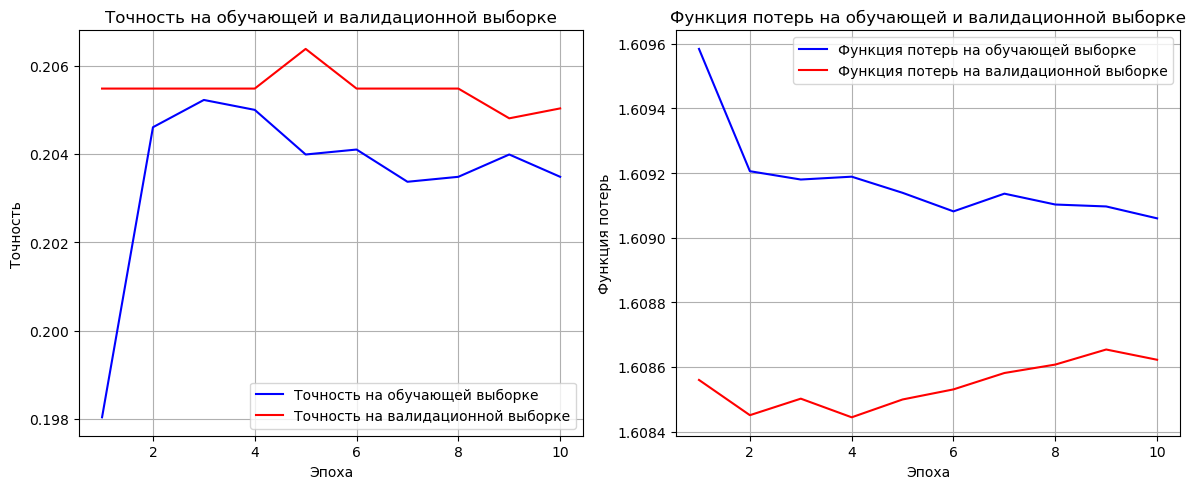

In [41]:
# Оценка на тестовом наборе
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Тестовая точность: {test_accuracy:.4f}")

# Сохранение полной модели (архитектура + веса)
model.save(os.path.join(checkpoint_dir, 'full_lstm_model_best_val_loss.keras'))

# Функция построения графиков точности и потерь
def plot_training_history(history):
    
    # Получаем данные из history
    acc = history.history['accuracy']          # Точность на тренировочном наборе
    val_acc = history.history['val_accuracy']  # Точность на валидационном наборе
    loss = history.history['loss']             # Потери на тренировочном наборе
    val_loss = history.history['val_loss']     # Потери на валидационном наборе
    epochs = range(1, len(acc) + 1)            # Список эпох

    # График точности
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'r-', label='Точность на валидационной выборке')
    plt.title('Точность на обучающей и валидационной выборке')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.grid(True)

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Функция потерь на обучающей выборке')
    plt.plot(epochs, val_loss, 'r-', label='Функция потерь на валидационной выборке')
    plt.title('Функция потерь на обучающей и валидационной выборке')
    plt.xlabel('Эпоха')
    plt.ylabel('Функция потерь')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Вызываем функцию для построения графиков
plot_training_history(history)

## Создание, обучение и тестирование CNN нейросети

#### Препроцессинг данных

Проход по папкам классов для разделения .csv файлов с логами полетов на перекрывающиеся сегменты (окна) с заданной длиной, и преобразование классов в one-hot.

In [46]:
# Функция для извлечения окон из одного файла
def extract_windows_from_file(file_path, class_label):
    df = pd.read_csv(file_path)
    
    # Извлекаем сырые данные (игнорируем time)
    data = df[['gx', 'gy', 'gz', 'ax', 'ay', 'az']].values  # Shape: (n_timesteps, 6)
    
    # Извлекаем окна с шагом
    windows = []
    labels = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start + window_size]
        windows.append(window)
        labels.append(class_label)
    
    return np.array(windows), np.array(labels)


# Параметры
data_dir = "Data_Real" # "Data_Real", "Data_MatLab"
window_size = 256
stride = 64

class_folders = os.listdir(f"{data_dir}") 
num_classes = len(class_folders)

# Сбор всех данных
all_windows = []
all_labels = []

for clas in class_folders:
    folder_path = os.path.join(data_dir, clas)   
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv') and "data_" not in file_name:

            file_path = os.path.join(folder_path, file_name)
            windows, labels = extract_windows_from_file(file_path, clas)
            
            all_windows.append(windows)
            all_labels.append(labels)


# Объединяем все окна и метки
X = np.concatenate(all_windows, axis=0)  # Shape: (n_samples, 256, 6)
y = np.concatenate(all_labels, axis=0)   # Shape: (n_samples, )
print(f"Общее количество образцов: {X.shape[0]}")

# One-hot encoding для меток 
y_onehot = to_categorical(y, num_classes=num_classes)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape} \nTest shape: {X_test.shape}")

Общее количество образцов: 55606
Train shape: (44484, 256, 6) 
Test shape: (11122, 256, 6)


#### Создание и обучение CNN нейросети

Максимальная достигнутая точность 97% на тестовых данных для Data_Matlab практически с первой подобранной архитектуры. Для Data_Real модель еще не обучал.

In [48]:
# Параметры
epochs = 2000            # Количество эпох обученмя 
early_stop_epochs = 600  # Количество эпох для ранней остановки
learning_rate = 0.0001   # Шаг обучения
time_steps = 256         # Длина окна
batch_size = 32          # Размер пакета

n_features = 6

# Модель 1D CNN
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, n_features)),
    # BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dropout(0.2),
    Dense(units=num_classes, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Создание папок для сохранения весов
checkpoint_dir = "Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_folder = rf'{checkpoint_dir}\CNN_checkpoints_C64_C128_D64_D16_D3_DROPOUT0.2_BS{batch_size}_E{epochs}_LR{learning_rate}'
os.makedirs(checkpoint_folder, exist_ok=True)

# Callback для сохранения весов
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, 'model_weights_epoch_{epoch:03d}.weights.h5'),
    save_weights_only=True,
    save_best_only=False,
    verbose=0
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_epochs, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint_callback],
    verbose=1
)

Epoch 1/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.3317 - loss: 1.4762 - val_accuracy: 0.6416 - val_loss: 1.0557
Epoch 2/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6528 - loss: 0.8649 - val_accuracy: 0.6902 - val_loss: 0.7247
Epoch 3/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7370 - loss: 0.6268 - val_accuracy: 0.7382 - val_loss: 0.6202
Epoch 4/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7670 - loss: 0.5503 - val_accuracy: 0.7438 - val_loss: 0.5643
Epoch 5/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7840 - loss: 0.5003 - val_accuracy: 0.7835 - val_loss: 0.4922
Epoch 6/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7995 - loss: 0.4604 - val_accuracy: 0.8299 - val_loss: 0.3818
Epoch 7/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8072 - loss: 0.4368 - val_accuracy: 0.7962 - val_loss: 0.4686
Epoch 8/200
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 

#### Построение графиков эффективности нейросети в зависимости от эпох обучения 

348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9106 - loss: 0.2198
Тестовая точность: 0.9106


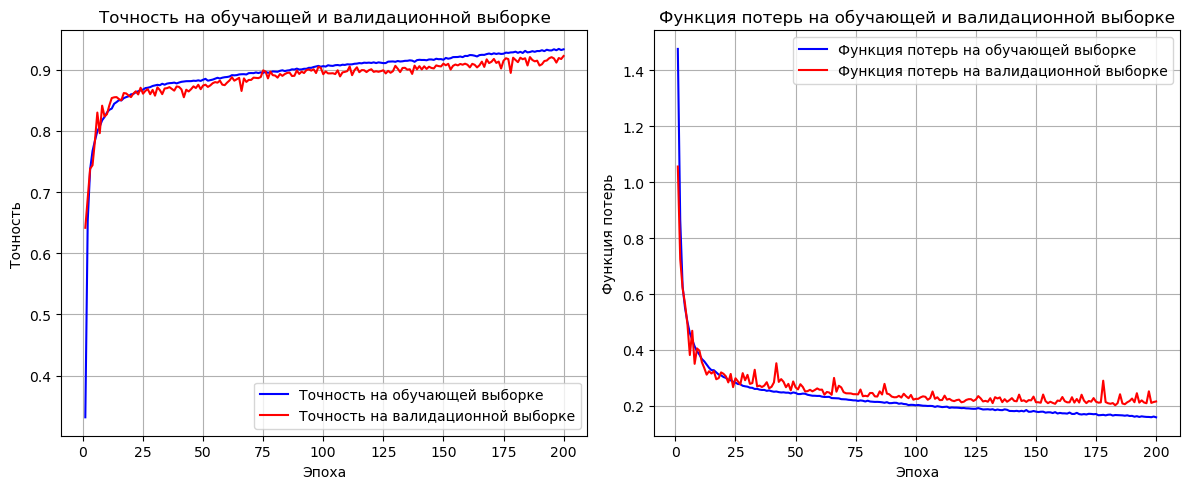

In [50]:
# Оценка на тестовом наборе
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Тестовая точность: {test_accuracy:.4f}")

# Сохранение полной модели (архитектура + веса)
model.save(os.path.join(checkpoint_dir, 'full_cnn_model_best_val_loss.keras'))

# Построение графиков
plot_training_history(history)

## Создание планов полётов для симуляционного комплекса


Параметры модели линейной регрессии:

Наклон: 0.3303 ⋅ X₁, -0.0793 ⋅ X₂
Смещение: 5.4969
R² (коэффициент детерминации): 0.9983

----------------------------------------------

--- Миссия 1 ---
Длина маршрута XY: 1218.13 м
Длина маршрута XYZ: 1224.77 м
Рассчётное время преодоления маршрута: 310.7 c



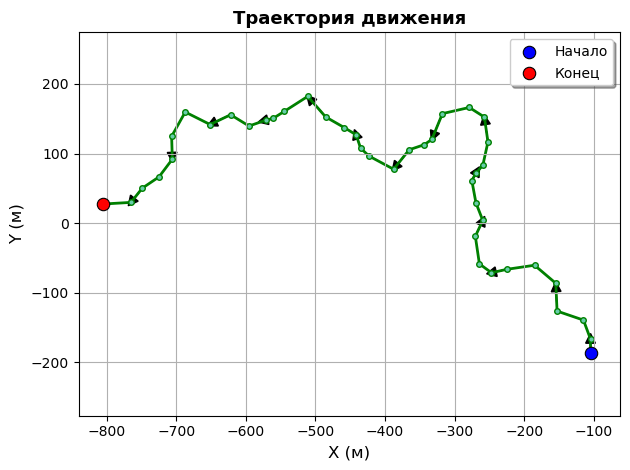


----------------------------------------------

--- Миссия 2 ---
Длина маршрута XY: 1069.32 м
Длина маршрута XYZ: 1077.03 м
Рассчётное время преодоления маршрута: 273.2 c



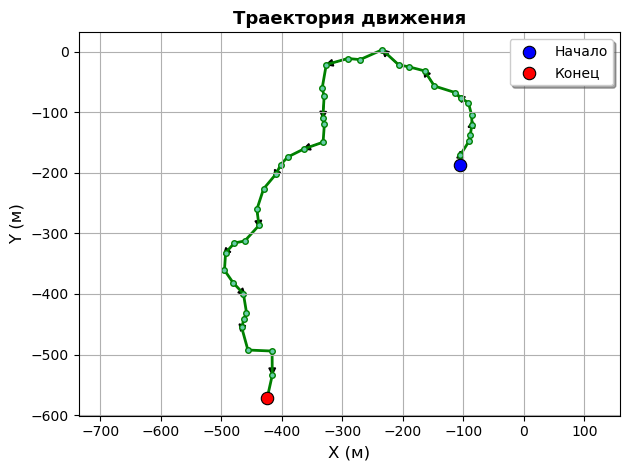


----------------------------------------------

--- Миссия 3 ---
Длина маршрута XY: 1087.46 м
Длина маршрута XYZ: 1095.53 м
Рассчётное время преодоления маршрута: 277.8 c



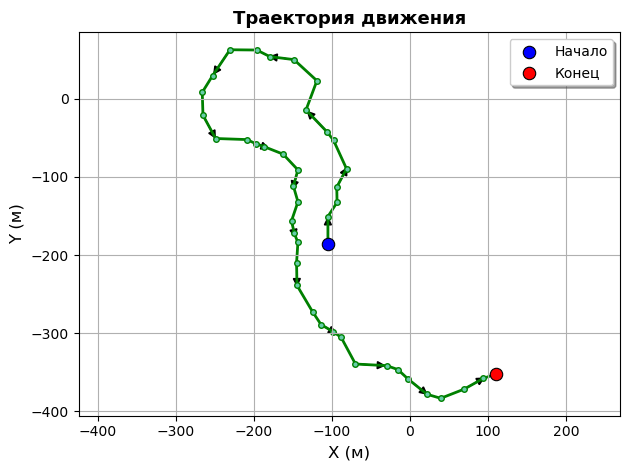


----------------------------------------------

--- Миссия 4 ---
Длина маршрута XY: 1198.99 м
Длина маршрута XYZ: 1204.51 м
Рассчётное время преодоления маршрута: 306.0 c



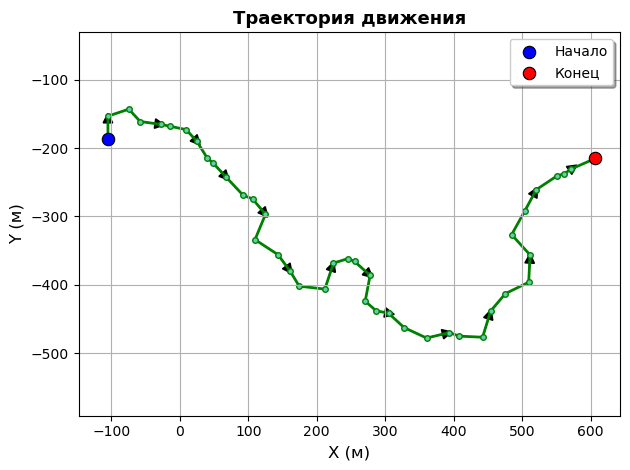


----------------------------------------------

--- Миссия 5 ---
Длина маршрута XY: 1331.19 м
Длина маршрута XYZ: 1333.73 м
Рассчётное время преодоления маршрута: 339.4 c



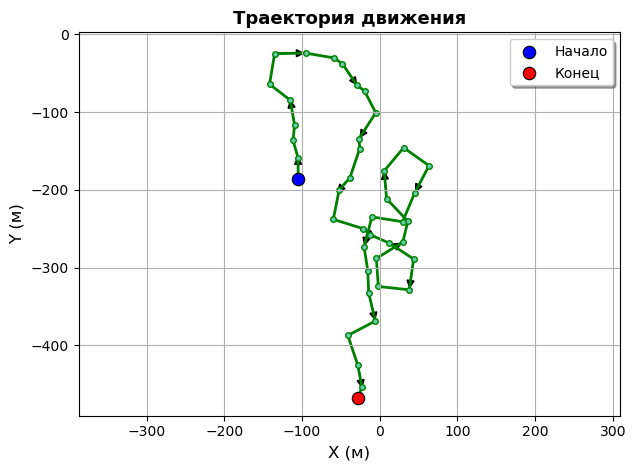


----------------------------------------------

--- Миссия 6 ---
Длина маршрута XY: 1191.45 м
Длина маршрута XYZ: 1198.55 м
Рассчётное время преодоления маршрута: 303.9 c



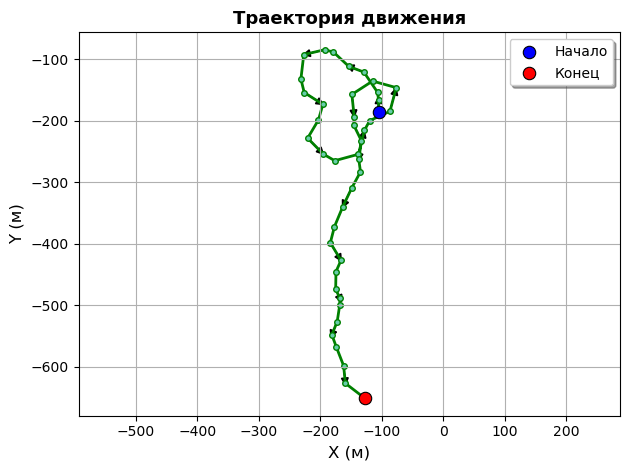


----------------------------------------------

--- Миссия 7 ---
Длина маршрута XY: 1072.03 м
Длина маршрута XYZ: 1077.20 м
Рассчётное время преодоления маршрута: 274.1 c



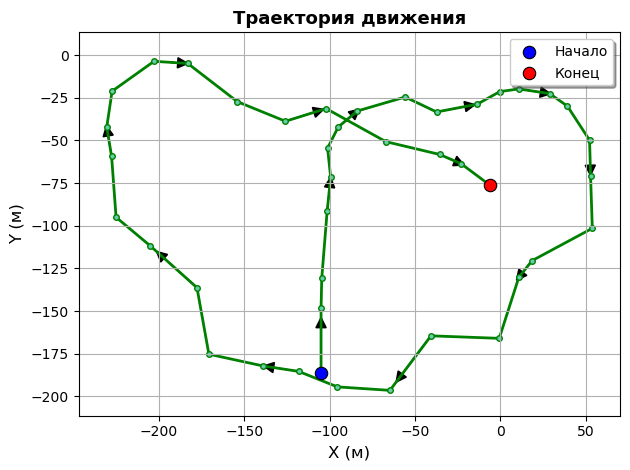


----------------------------------------------

--- Миссия 8 ---
Длина маршрута XY: 1228.48 м
Длина маршрута XYZ: 1236.05 м
Рассчётное время преодоления маршрута: 313.2 c



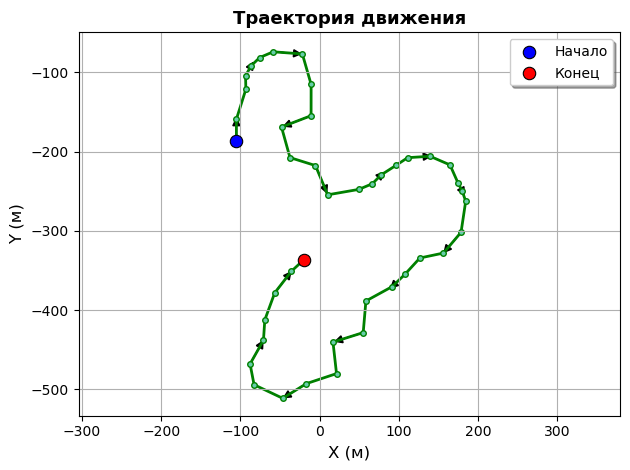


----------------------------------------------

--- Миссия 9 ---
Длина маршрута XY: 1294.66 м
Длина маршрута XYZ: 1300.00 м
Рассчётное время преодоления маршрута: 330.0 c



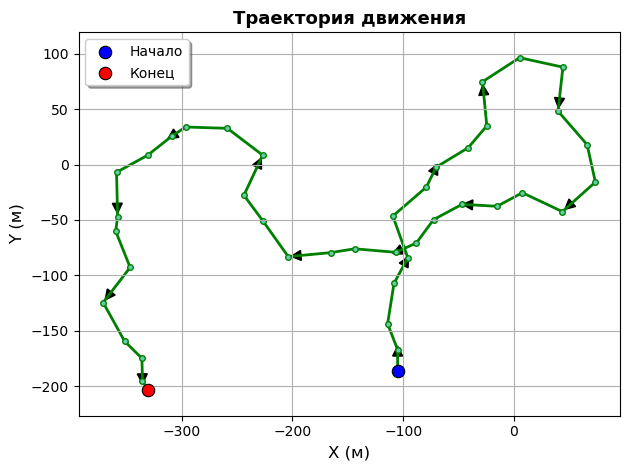


----------------------------------------------

--- Миссия 10 ---
Длина маршрута XY: 1126.54 м
Длина маршрута XYZ: 1132.93 м
Рассчётное время преодоления маршрута: 287.7 c



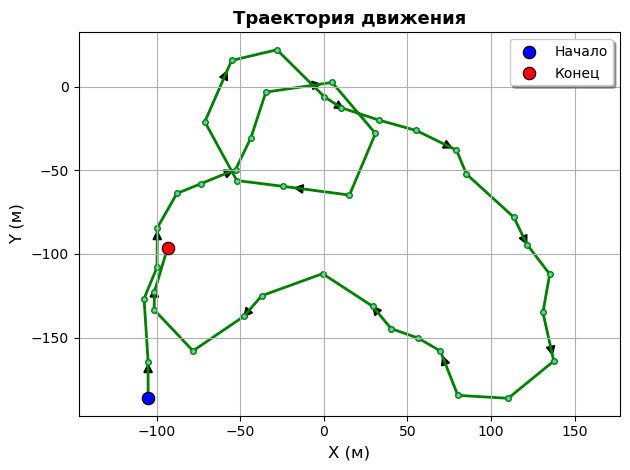

In [54]:
def trainLinearRegressionModel(print_information=True):
    # Данные для обучения (с ранее проведенных полётов)
    X = np.array([[890.67, 900.38], [915.6, 940.28], [1033.59, 1052.36], [1137.73, 1163.86], 
                  [1045.34, 1062.41], [1091.98, 1109.99], [1139.31, 1150.8], [1305.26, 1324.49]])
    y = np.array([228, 233, 262, 290, 265.5, 280.5, 291.5, 330])
    
    # Создание, обучение и прогноз модели
    model = LinearRegression()
    model.fit(X, y)

    if print_information:
        y_pred = model.predict(X)
        print(f"\nПараметры модели линейной регрессии:\n")
        print(f"Наклон: {model.coef_[0]:.4f} ⋅ X₁, {model.coef_[1]:.4f} ⋅ X₂")
        print(f"Смещение: {model.intercept_:.4f}")
        print(f"R² (коэффициент детерминации): {r2_score(y, y_pred):.4f}")
        
    return model


def metresToDegrees(X, Y, home=[55.7558, 37.6173, 0]):
    newX = [55.7541275]
    newY = [37.6156273]
    for x, y in zip(X[1:], Y[1:]):
        newX.append(round(home[0] + x * 8.9817436e-06, 10))
        newY.append(round(home[1] + y * 1.59271828e-05, 10))
        
    return newX, newY


def plotMission(x, y):
    plt.plot(x, 
             y, 
             color='green',  
             marker='o', 
             mfc='mediumaquamarine', 
             mec='green', 
             linewidth=2, 
             ms=4, 
             zorder=1,
             linestyle='solid')
    
    plt.scatter(x[0], 
                y[0], 
                color='blue', 
                s=80, 
                edgecolor='black', 
                linewidth=0.8, 
                zorder=2,
                label='Начало')
    
    plt.scatter(x[-1], 
                y[-1], 
                color='red', 
                s=80, 
                edgecolor='black', 
                linewidth=0.8, 
                zorder=2,
                label='Конец')

    # Создание стрелок направления (динамическая коррекция размера)
    arrow_size = min(max(3 + (round(max(map(abs, [max(x) - min(x), max(y) - min(y)]))) - 130) // 50, 2), 20)  
    for i in range(0, 42, 3):
        plt.arrow(x[i], 
                  y[i], 
                  (x[i + 1] - x[i]) * 0.7, 
                  (y[i + 1] - y[i]) * 0.7, 
                  head_width=arrow_size, 
                  head_length=arrow_size, 
                  zorder=0,
                  fc='k', 
                  ec='k')
    
    plt.grid()
    
    plt.title('Траектория движения', 
              fontweight='demibold', 
              fontsize=13)
    
    plt.xlabel('X (м)', 
               fontsize='large', 
               fontweight='medium')
    
    plt.ylabel('Y (м)', 
               fontsize='large', 
               fontweight='medium')
    
    plt.legend(fontsize=10, 
               shadow=True, 
               loc='best')
    
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def printFlightInformation(distanceXY, distanceXYZ):
    print('\n', '-' * 46, sep='')
    print(f"\n--- Миссия {k+1} ---")
    print(f"Длина маршрута XY: {distanceXY:.2f} м")
    print(f"Длина маршрута XYZ: {distanceXYZ:.2f} м")

    pred = model.predict([[distanceXY, distanceXYZ]])
    print(f"Рассчётное время преодоления маршрута: {pred[0]:.1f} c\n")


def writeMissionToFile(mission):
    with open('baseMission.plan', 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    for i, item in enumerate(data['mission']['items']):
        item['params'][-3:] = [mission[k][j][i] for j in range(3)]
    
    with open(f'Missions\Mission_{k+1}.plan', 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)


# Расстояние между точками (не рекомендуется ставить min_distance < 10)
min_distance = 10
max_distance = 40

# Количество миссий
n_missions = 10

# Начальная точка
x = [-105.022]
y = [-186.212]
z = [-15]

model = trainLinearRegressionModel()
mission_init = [[x, y, z] for _ in range(n_missions)]

os.makedirs("Missions", exist_ok=True)

for k in range(n_missions):
    mission = deepcopy(mission_init) 
    
    # Начальное направление 90° (прямо) и дистанция до первой точки 20 м
    current_angle = np.pi/2 
    distance = 20
    
    for i in range(0, 41):
        # Случайное изменение угла
        angle = np.pi/2 * distance / max_distance
        angle_change = np.random.uniform(-angle, angle)
        current_angle += 0 if i == 0 else angle_change
    
        # Случайное расстояние 
        b = abs(angle_change / (np.pi/2) * 3) if abs(angle_change) > np.pi/4 else 1
        distance = min(np.random.uniform(min_distance, max_distance) * b, max_distance)
        
        # Новая точка
        new_x_point = round(mission[k][0][-1] + distance * np.cos(current_angle), 3)
        new_y_point = round(mission[k][1][-1] + distance * np.sin(current_angle), 3)
        new_z_point = min(round(random.triangular(mission[k][2][-1] - distance / 3.5, mission[k][2][-1] + distance / 3.5), 3), -1)
        
        mission[k][0].append(new_x_point)
        mission[k][1].append(new_y_point)
        mission[k][2].append(new_z_point)
    
    # Рассчет длины маршрута
    distanceXY = sum(np.sqrt(np.diff(mission[k][0])**2 + np.diff(mission[k][1])**2))
    distanceXYZ = sum(np.sqrt(np.diff(mission[k][0])**2 + np.diff(mission[k][1])**2 + np.diff(mission[k][2])**2))

    # Вывод информации о миссии
    printFlightInformation(distanceXY, distanceXYZ)
    plotMission(mission[k][0], mission[k][1])

    # Преобразование координат, заданных в метрах, в широту и долготу
    mission[k][0], mission[k][1] = metresToDegrees(mission[k][1], mission[k][0])
    
    # Запись данных в файл
    writeMissionToFile(mission)
